In [86]:
import time
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm
import matplotlib
import numpy as np
import uproot
from matplotlib import cm
from iminuit import Minuit
from scipy.optimize import fsolve
from scipy.interpolate import RectBivariateSpline
matplotlib.rcParams['figure.facecolor'] = 'white'

# Here the signal PDF is defined

The X17 decay has been simulated for a given set of masses. Morphing is used to interpolate the reference morphing template, which are then added to the background PDFs and treated as such.

In [87]:

def BBliteBeta(Di, mu0, mueff):
    betas = (Di + mueff)/(mu0 + mueff + (mu0 == 0))
    return betas + (betas == 0)

# Python implementation of momentum morphing class algorithm in https://arxiv.org/pdf/1410.7388.pdf
import numpy as np
from scipy.interpolate import RectBivariateSpline
# The class takes as input a numpy array with the first axis being the morphing parameter, the list of m parameters and the reference value of the morphing parameter

class MorphTemplate1D:
    def __init__(self, hist, ms, m0):
        self.hist = hist
        self.originalMS = ms
        self.maxMs = max(ms)
        self.minMs = min(ms)
        self.n = len(self.hist)
        self.ms = ms
        self.m0 = m0
        self.m0Index = self.findm0()
        self.ms = self.ChebyshevNodes(ms)
        self.M = self.computMmatrix()
    
    # Compute Chebyshev nodes
    def ChebyshevNodes(self, ms):
        k = (ms - self.minMs)/(self.maxMs - self.minMs)*(self.n-1) + 1
        res = np.cos((k - 1)*np.pi/(self.n-1))
        return res
    
    # Find the index of m0 in ms
    def findm0(self):
        if self.m0 not in self.ms:
            return 0
        else:
            return np.where(self.ms == self.m0)[0][0]
    
    # Compute the M matrix
    def computMmatrix(self):
        n = len(self.hist)
        
        M = np.ones((n, n))
        M = (M*(self.ms - self.ms[self.m0Index])).transpose()
        M = np.power(M, np.arange(n))
        M = np.linalg.inv(M).transpose()
        return M
    
    # Compute ci coefficients
    def computCi(self, m):
        deltam = np.power(m - self.ms[self.m0Index], np.linspace(0, len(self.hist) - 1, len(self.hist)))
        c = np.dot(self.M, deltam)
        return c

    # Compute the morphed template
    def morphTemplate(self, x, hist=None):
        # Apply Chebyshev nodes
        smear = self.ChebyshevNodes(x)
        ci = self.computCi(smear)
        if hist is not None:
            thist = np.swapaxes(hist, 0, len(hist.shape) - 1)
        else:
            thist = np.swapaxes(self.hist, 0, len(self.hist.shape) - 1)
        res = np.dot(thist, ci).transpose()
        res = res*(res > 0)
        return res

class histHandler:
    def __init__(self, channels, dataName, signalName, BKGnames, var1, var2, alphaNames = [], alphavalues = [], alphaRefs = [], TotalMCStatistics = [], masses = [], massRef = 16.9):
        self.channels = channels
        self.dataName = dataName
        self.signalName = signalName
        self.BKGnames = BKGnames
        self.alphaNames = alphaNames
        self.alphavalues = alphavalues
        self.alphaRefs = alphaRefs
        self.alphaRefsIndex = np.where(np.array(self.alphavalues).transpose() == self.alphaRefs)[0][0]
        self.TotalMCStatistics = TotalMCStatistics
        self.masses = masses
        self.massRef = massRef
        if len(self.masses) > 0:
            self.massIndex = np.where(np.array(self.masses) == self.massRef)[0][0]
        self.var1 = var1
        self.var2 = var2
        self.DataArray = []
        self.DataArrayToy = []
        self.SignalArray = []
        self.SignalArrayToy = []
        self.SignalArrayNuisance = []
        self.SignalArrayNuisance5Sigma = []
        self.SignalArrayNuisance5SigmaArray = []
        self.SignalArrayNuisanceToy = []
        self.SignalArrayNuisance5SigmaToy = []
        self.SignalArrayNuisance5SigmaArrayToy = []
        self.nMCsSignal = []
        self.nMCsSignalFractions = []
        self.BKGarray = []
        self.BKGarrayCumSum = []
        self.BKGarrayNuisance = []
        self.BKGarrayNuisance5Sigma = []
        self.BKGarrayNuisance5SigmaArray = []
        self.BKGarrayNuisanceCumSum = []
        self.BKGarrayToy = []
        self.BKGarrayNuisance5SigmaToy = []
        self.BKGarrayNuisance5SigmaArrayToy = []
        self.nMCs = []
        self.nMCsFractions = []
        self.MassMorpher = []
        self.morphers = []
        self.initializeArrays()
        
    # Prepare histograms
    def initializeArrays(self):
        # Produce 1D hist of data
        hist = []
        for channel in self.channels.keys():
            hist.append(self.channels[channel][self.dataName].flatten())
        self.DataArray = np.concatenate(hist)
        
        # Produce 1D array of signal
        hist = []
        nMCs = []
        if len(self.masses) > 0:
            for i in range(len(self.masses)):
                thist = []
                for channel in self.channels.keys():
                    thist.append(self.channels[channel][self.signalName+'%.1f'%self.masses[i]].flatten())
                hist.append(np.concatenate(thist))
                nMCs.append(hist[-1].sum())
            self.SignalArray = np.array(hist)
            self.nMCsSignal = np.array(nMCs)
        
        # Produce 1D BKG arrays
        hist = []
        nMCs = []
        histCumSum = []
        for i in range(len(self.BKGnames)):
            thist = []
            for channel in self.channels.keys():
                thist.append(self.channels[channel][self.BKGnames[i]].flatten())
            hist.append(np.concatenate(thist))
            histCumSum.append(hist[-1].cumsum())
            nMCs.append(hist[-1].sum())
        self.BKGarray = np.array(hist)
        self.BKGarrayToy = np.array(hist)
        self.BKGarrayCumSum = np.array(histCumSum)
        self.nMCs = np.array(nMCs)
        
        # Produce hists for mass morphing
        # The output is a histogram to be added to BKGarray and BKGarrayNuisance sets when estimating the final distributions
        # The first index runs on the masses
        # On each position the format is the same as for each background
        hist = []
        nMCs = []
        if len(self.masses) > 0:
            for i in range(len(self.masses)):
                thist = []
                for channel in self.channels.keys():
                    thist.append(self.channels[channel][self.signalName+'%.1f'%self.masses[i]].flatten())
                hist.append(np.concatenate(thist))
                nMCs.append(hist[-1].sum())
            self.SignalArray = np.array(hist)
            self.nMCsSignal = np.array(nMCs)
            self.SignalArrayToy = np.array(hist)
            self.MassMorpher = MorphTemplate1D(self.SignalArray, self.masses, self.massRef)
            
            hist = []
            if len(self.alphaNames) > 0:
                for m in range(len(self.masses)):
                    histSet = []
                    thistSet = []
                    for a in range(len(self.alphaNames)):
                        thist_5dn = []
                        thist_4dn = []
                        thist_3dn = []
                        thist_2dn = []
                        thist_dn = []
                        thist = []
                        thist_up = []
                        thist_2up = []
                        thist_3up = []
                        thist_4up = []
                        thist_5up = []
                        for channel in self.channels.keys():
                            thist_5dn.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_5dn"].flatten())
                            thist_4dn.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_4dn"].flatten())
                            thist_3dn.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_3dn"].flatten())
                            thist_2dn.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_2dn"].flatten())
                            thist_dn.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_1dn"].flatten())
                            thist.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]].flatten())
                            thist_up.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_1up"].flatten())
                            thist_2up.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_2up"].flatten())
                            thist_3up.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_3up"].flatten())
                            thist_4up.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_4up"].flatten())
                            thist_5up.append(self.channels[channel][self.signalName+'%.1f'%self.masses[m]+self.alphaNames[a]+"_5up"].flatten())
                        histSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)]))
                        thistSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)])/(self.SignalArray[self.massIndex] + 1*(self.SignalArray[self.massIndex] == 0)))
                    if len(self.alphaRefs) > 0 and len(self.alphavalues) > 0:
                        #thist = np.swapaxes(thistSet, 1, 2)
                        #thist = np.concatenate(thist, axis=0)
                        #thist = np.swapaxes(thist, 0, 1)
                        self.SignalArrayNuisance5SigmaArrayToy.append(np.array(thistSet))
                    self.SignalArrayNuisance5SigmaToy.append(np.array(histSet))
                    self.SignalArrayNuisance5Sigma.append(np.array(histSet))
            self.SignalArrayNuisance5Sigma = np.array(self.SignalArrayNuisance5Sigma)
            self.SignalArrayNuisance5SigmaArray = np.array(self.SignalArrayNuisance5SigmaArrayToy)
            self.SignalArrayNuisance5SigmaToy = np.array(self.SignalArrayNuisance5SigmaToy)
            self.SignalArrayNuisance5SigmaArrayToy = np.array(self.SignalArrayNuisance5SigmaArrayToy)
        
        # Produce 1D histset for shape nuisance parameters
        # The final array has three indeces:
        # - the first one running on the systematics
        # - the second one running on the bins
        # - the third one running between the -1, 0 and +1 sigma variation of the systematic
        hist = []
        histCumSum = []
        if len(self.alphaNames) > 0:
            for a in range(len(self.alphaNames)):
                histSet = []
                histSetCumSum = []
                for b in range(len(self.BKGarray)):
                    thist_dn = []
                    thist_up = []
                    thist = []
                    for channel in self.channels.keys():
                        thist_dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_dn"].flatten())
                        thist_up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_up"].flatten())
                        thist.append(self.channels[channel][self.BKGnames[b]].flatten())
                    
                    histSet.append(np.array([np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up)]))
                    histSetCumSum.append(histSet[-1].cumsum(axis=1))
                hist.append(histSet)
                histCumSum.append(histSetCumSum)
            self.BKGarrayNuisance = np.array(hist)
            self.BKGarrayNuisanceCumSum = np.array(histCumSum)
            
        hist = []
        if len(self.alphaNames) > 0:
            for a in range(len(self.alphaNames)):
                histSet = []
                thistSet = []
                for b in range(len(self.BKGarray)):
                    thist_5dn = []
                    thist_4dn = []
                    thist_3dn = []
                    thist_2dn = []
                    thist_dn = []
                    thist_up = []
                    thist_2up = []
                    thist_3up = []
                    thist_4up = []
                    thist_5up = []
                    thist = []
                    for channel in self.channels.keys():
                        thist_5dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_5dn"].flatten())
                        thist_4dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_4dn"].flatten())
                        thist_3dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_3dn"].flatten())
                        thist_2dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_2dn"].flatten())
                        thist_dn.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_1dn"].flatten())
                        thist.append(self.channels[channel][self.BKGnames[b]].flatten())
                        thist_up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_1up"].flatten())
                        thist_2up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_2up"].flatten())
                        thist_3up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_3up"].flatten())
                        thist_4up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_4up"].flatten())
                        thist_5up.append(self.channels[channel][self.BKGnames[b]+self.alphaNames[a]+"_5up"].flatten())
                    
                    # Morphing happens on a ratio so we can stack the effect just by multiplying the factors
                    histSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)]))
                    thistSet.append(np.array([np.concatenate(thist_5dn), np.concatenate(thist_4dn), np.concatenate(thist_3dn), np.concatenate(thist_2dn), np.concatenate(thist_dn), np.concatenate(thist), np.concatenate(thist_up), np.concatenate(thist_2up), np.concatenate(thist_3up), np.concatenate(thist_4up), np.concatenate(thist_5up)])/(self.BKGarray[b] + 1*(self.BKGarray[b] == 0)))
                hist.append(histSet)
                if len(self.alphaRefs) > 0 and len(self.alphavalues) > 0:
                    thist = np.swapaxes(thistSet, 1, 2)
                    thist = np.concatenate(thist, axis=0)
                    thist = np.swapaxes(thist, 0, 1)
                    self.morphers.append(MorphTemplate1D(thist, self.alphavalues[a], self.alphaRefs[a]))
                    self.BKGarrayNuisance5SigmaArrayToy.append(thist)
            self.BKGarrayNuisance5Sigma = np.array(hist)
            self.BKGarrayNuisance5SigmaArray = np.array(self.BKGarrayNuisance5SigmaArrayToy)
            self.BKGarrayNuisance5SigmaToy = np.array(hist)
            self.BKGarrayNuisance5SigmaArrayToy = np.array(self.BKGarrayNuisance5SigmaArrayToy)
    
    def getMorphedMassArray(self, mass, massArray = []):
        if len(massArray) == 0:
            morphed = self.MassMorpher.morphTemplate(mass)
        else:
            morphed = self.MassMorpher.morphTemplate(mass, hist = massArray)
            if len(morphed.shape) > 1:
                morphed = np.swapaxes(morphed, 0, 1)
        return morphed*(morphed > 1e-10)
    
    def getMorphedBKGarray(self, morph = [], mass = None):
        if mass is not None:
            tempArray = self.getMorphedMassArray(mass, massArray=self.SignalArrayNuisance5Sigma)
            temphists = np.insert(self.BKGarray, 0, tempArray[0, self.alphaRefsIndex, :], axis=0)
            tempArray /= (temphists[0] + 1*(temphists[0] == 0))
            tempArray = np.concatenate((tempArray, self.BKGarrayNuisance5SigmaArray), axis = 2)
        else:
            temphists = np.copy(self.BKGarray)
            tempArray = np.copy(self.BKGarrayNuisance5SigmaArray)
        
        temphists = temphists + 1*(temphists == 0)
        
        for i in range(len(morph)):
            morphed = self.morphers[i].morphTemplate(morph[i], hist = tempArray[i])
            morphed = np.reshape(morphed, temphists.shape)
            temphists *= morphed
        temphists = temphists*(temphists > 1e-10)
        return temphists
    
    def getMorphedBKGarrayToy(self, morph = [], mass = None):
        if mass is not None:
            tempArray = self.getMorphedMassArray(mass, massArray=self.SignalArrayNuisance5SigmaToy)
            temphists = np.insert(self.BKGarrayToy, 0, tempArray[0, self.alphaRefsIndex, :], axis=0)
            tempArray /= (temphists[0] + 1*(temphists[0] == 0))
            tempArray = np.concatenate((tempArray, self.BKGarrayNuisance5SigmaArrayToy), axis = 2)
        else:
            temphists = np.copy(self.BKGarrayToy)
            tempArray = np.copy(self.BKGarrayNuisance5SigmaArrayToy)
        
        temphists = temphists + 1*(temphists == 0)
        
        for i in range(len(morph)):
            morphed = self.morphers[i].morphTemplate(morph[i], hist = tempArray[i])
            morphed = np.reshape(morphed, temphists.shape)
            temphists *= morphed
        temphists = temphists*(temphists > 1e-10)
        return temphists
    
    def getEstimate(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph, mass = mass)
            totMCs = np.sum(temphists, axis=1)
        elif mass is not None:
            temphists = np.insert(self.BKGarray, 0, self.getMorphedMassArray(mass), axis=0)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, totMCs[0])
            else:
                totMCs = self.TotalMCStatistics
        if multiplier:
            totMCs = np.ones(totMCs.shape)
        temphists *= betas*nus
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists
    
    def getEstimateToy(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarrayToy(morph, mass = mass)
        elif mass is not None:
            temphists = np.insert(self.BKGarrayToy, 0, self.getMorphedMassArray(mass, massArray=self.SignalArrayToy), axis=0)
        else:
            temphists = np.copy(self.BKGarrayToy)
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, np.sum(temphists, axis=1)[0])
            else:
                totMCs = self.TotalMCStatistics
        else:
            totMCs = np.sum(temphists, axis=1)
        if multiplier:
            totMCs = np.ones(totMCs.shape)
        temphists *= betas*nus
        temphists = np.matmul(yields/totMCs, temphists)
        return temphists

    def getEstimateUncertainty(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph, mass = mass)
            totMCs = np.sum(temphists, axis=1)
        elif mass is not None:
            temphists = np.insert(self.BKGarray, 0, self.getMorphedMassArray(mass), axis=0)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, totMCs[0])
            else:
                totMCs = self.TotalMCStatistics
        if multiplier:
            totMCs = np.ones(totMCs.shape)
            
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return np.sqrt(temphists)
    
    def getEstimateUncertaintyToy(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temp = self.getMorphedBKGarrayToy(morph, mass = mass)
        elif mass is not None:
            temp = np.insert(self.BKGarrayToy, 0, self.getMorphedMassArray(mass, massArray=self.SignalArrayToy), axis=0)
        else:
            temp = np.copy(self.BKGarrayToy)
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, np.sum(temp, axis=1)[0])
            else:
                totMCs = self.TotalMCStatistics
        else:
            totMCs = np.sum(temp, axis=1)
        if multiplier:
            totMCs = np.ones(totMCs.shape)
        
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return np.sqrt(temp)
    
    def getEstimateVariance(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temphists = self.getMorphedBKGarray(morph, mass = mass)
            totMCs = np.sum(temphists, axis=1)
        elif mass is not None:
            temphists = np.insert(self.BKGarray, 0, self.getMorphedMassArray(mass), axis=0)
            totMCs = np.sum(temphists, axis=1)
        else:
            temphists = np.copy(self.BKGarray)  # Create a copy of self.BKGarray
            totMCs = self.nMCs
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, totMCs[0])
            else:
                totMCs = self.TotalMCStatistics
        if multiplier:
            totMCs = np.ones(totMCs.shape)
        
        temphists *= np.power(betas*nus, 2)
        temphists = np.matmul(np.power(yields/totMCs, 2), temphists)
        return temphists
    
    def getEstimateVarianceToy(self, yields, betas = 1, nus=1, morph = [], mass = None, multiplier = False):
        if len(morph) > 0:
            temp = self.getMorphedBKGarrayToy(morph, mass = mass)
        elif mass is not None:
            temp = np.insert(self.BKGarrayToy, 0, self.getMorphedMassArray(mass, massArray=self.SignalArrayToy), axis=0)
        else:
            temp = np.copy(self.BKGarrayToy)
        
        # At the moment only the X17s within the channels are counted
        # Actually, the TotalMCStatistics can be obtained by the morpher as well, as the interpolation is done with a linear map
        if len(self.TotalMCStatistics) > 0:
            if mass is not None:
                totMCs = np.insert(self.TotalMCStatistics, 0, np.sum(temp, axis=1)[0])
            else:
                totMCs = self.TotalMCStatistics
        else:
            totMCs = np.sum(temp, axis=1)
        if multiplier:
            totMCs = np.ones(totMCs.shape)
        
        temp *= np.power(betas*nus, 2)
        temp = np.matmul(np.power(yields/totMCs, 2), temp)
        return temp

    def generateToy(self, yields, betas = 1, nus=1, fluctuateTemplates = True, morph = [], mass = None):
        if fluctuateTemplates:
            #temphists *= betas*nus
            if len(morph) > 0:
                # Sample all reference templates
                
                if mass is not None:
                    # Prepare signal templates
                    temphists = np.copy(self.SignalArrayNuisance5Sigma)
                    temphists = (np.random.poisson(temphists)).astype(float)
                    self.SignalArrayNuisance5SigmaToy = np.copy(temphists)
                    
                    # Get SignalArrayToy, they are redundant
                    self.SignalArrayToy = np.copy(self.SignalArrayNuisance5SigmaToy[:, 0, self.alphaRefsIndex, :])
                
                # Prepare BKG templates
                temphists = np.copy(self.BKGarrayNuisance5Sigma)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayNuisance5SigmaToy = np.copy(temphists)
                
                # Get BKGarrayToy, they are redundant
                self.BKGarrayToy = np.copy(self.BKGarrayNuisance5SigmaToy[0, :, (self.alphaRefsIndex), :])
                for i in range(len(morph)):
                    if i != 0:
                        if mass is not None:
                            self.SignalArrayNuisance5SigmaToy[:, i, (self.alphaRefsIndex), :] = np.copy(self.SignalArrayToy)
                        self.BKGarrayNuisance5SigmaToy[i, :, (self.alphaRefsIndex), :] = np.copy(self.BKGarrayToy)
                
                # Scale the BKGarrayNuisance5SigmaToy
                for i in range(len(morph)):
                    temphists = np.copy(self.BKGarrayNuisance5SigmaToy[i])
                    temphists = np.swapaxes(temphists, 1, 2)
                    temphists = np.concatenate(temphists, axis=0)
                    temphists = np.swapaxes(temphists, 0, 1)/(np.concatenate(self.BKGarrayToy, axis=0) + 1*(np.concatenate(self.BKGarrayToy, axis=0) == 0))
                    self.BKGarrayNuisance5SigmaArrayToy[i] = np.copy(temphists)
            else:
                if mass is not None:
                    # Prepare signal templates
                    temphists = np.copy(self.SignalArray)
                    temphists = (np.random.poisson(temphists)).astype(float)
                    self.SignalArrayToy = np.copy(temphists)
                
                # Prepare BKG templates
                temphists = np.copy(self.BKGarray)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayToy = np.copy(temphists)
        else:
            if mass is not None:
                # Prepare signal templates
                self.SignalArrayToy = np.copy(self.SignalArray)
            
            # Prepare BKG templates
            self.BKGarrayToy = np.copy(self.BKGarray)
        
        temphists = self.getEstimateToy(yields, betas, nus, morph, mass = mass)
        if (temphists < 0).any():
            print("Warning: negative prediction in toy generation")
            print(temphists)
            print("Yields: ", yields)
            print("Betas: ", betas)
        temphists = np.random.poisson(temphists).astype(float)
        self.DataArrayToy = np.copy(temphists)
        
        if fluctuateTemplates:
            #temphists *= betas*nus
            if len(morph) > 0:
                # Sample all reference templates
                # Our best estimate of the templates stays Gianluca's MC even after fitting,
                # we only obtain some correction factors (BB betas) for the generation of the data
                # So the templates, both for generation and fitting are both extracted separately by Gianluca's MC
                
                if mass is not None:
                    # Prepare signal templates
                    temphists = np.copy(self.SignalArrayNuisance5Sigma)
                    temphists = (np.random.poisson(temphists)).astype(float)
                    self.SignalArrayNuisance5SigmaToy = np.copy(temphists)
                    
                    # Get SignalArrayToy, they are redundant
                    self.SignalArrayToy = np.copy(self.SignalArrayNuisance5SigmaToy[:, 0, self.alphaRefsIndex, :])
                
                # Prepare BKG templates
                temphists = np.copy(self.BKGarrayNuisance5Sigma)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayNuisance5SigmaToy = np.copy(temphists)
                
                # Get BKGarrayToy, they are redundant
                self.BKGarrayToy = np.copy(self.BKGarrayNuisance5SigmaToy[0, :, (self.alphaRefsIndex), :])
                for i in range(len(morph)):
                    if i != 0:
                        if mass is not None:
                            self.SignalArrayNuisance5SigmaToy[:, i, (self.alphaRefsIndex), :] = np.copy(self.SignalArrayToy)
                        self.BKGarrayNuisance5SigmaToy[i, :, (self.alphaRefsIndex), :] = np.copy(self.BKGarrayToy)
                
                # Scale the BKGarrayNuisance5SigmaToy
                for i in range(len(morph)):
                    temphists = np.copy(self.BKGarrayNuisance5SigmaToy[i])
                    temphists = np.swapaxes(temphists, 1, 2)
                    temphists = np.concatenate(temphists, axis=0)
                    temphists = np.swapaxes(temphists, 0, 1)/(np.concatenate(self.BKGarrayToy, axis=0) + 1*(np.concatenate(self.BKGarrayToy, axis=0) == 0))
                    self.BKGarrayNuisance5SigmaArrayToy[i] = np.copy(temphists)
            else:
                if mass is not None:
                    # Prepare signal templates
                    temphists = np.copy(self.SignalArray)
                    temphists = (np.random.poisson(temphists)).astype(float)
                    self.SignalArrayToy = np.copy(temphists)
                
                temphists = np.copy(self.BKGarray)
                temphists = (np.random.poisson(temphists)).astype(float)
                self.BKGarrayToy = np.copy(temphists)
        else:
            if mass is not None:
                # Prepare signal templates
                self.SignalArrayToy = np.copy(self.SignalArray)
            self.BKGarrayToy = np.copy(self.BKGarray)


## Get MC samples

In [88]:
channels = {
    'ch1': {
        'name': 'X17 2023, low angle, low energy',
        'Esum': [15, 16, 2], # [min, max, nBins]
        'Angle': [0, 80, 16]
    },
    'ch2': {
        'name': 'X17 2023, low angle, high energy',
        'Esum': [16, 20, 8], # [min, max, nBins]
        'Angle': [30, 80, 10]
    },
    'ch3': {
        'name': 'X17 2023, low energy, high angle',
        'Esum': [15, 16, 1],
        'Angle': [80, 160, 4]
    },
    'ch4': {
        'name': 'X17 2023, low energy, high angle, last bin',
        'Esum': [15, 16, 1],
        'Angle': [160, 170, 1]
    },
    'ch5': {
        'name': 'X17 2023, high energy, high angle',
        'Esum': [16, 20, 2],
        'Angle': [80, 170, 9]
    },
}
massElectron = 0.5109989461 #MeV
alphares = 0.005
alphafield = 0.005

esumCutLow = 16
esumCutHigh = 20
angleCutLow = 115
angleCutHigh = 160

#esumCutLow = 20
#esumCutHigh = 15
#angleCutLow = 180
#angleCutHigh = 0

dataRunMax = 511000

workDir = './results/'
dataFile = 'data2023.root'
MCFile = 'MC2023tot.root'

In [89]:
matplotlib.rcParams.update({'font.size': 30})
def plotChannels(channels, sample='dataHist', title='Data'):
    matplotlib.rcParams.update({'font.size': 30})
    hists = []
    maxBin = 0
    minEsum = 100
    maxEsum = 0
    minAngle = 180
    maxAngle = 0
    # check if sample is a 
    if type(sample) == list:
        fig = plt.figure(figsize=(14*len(sample)*1.1, 14), dpi=100)
        plt.suptitle(title)
        numberOfSubPlots = len(sample)
        for s in sample:
            hists = []
            plt.subplot(1, numberOfSubPlots, sample.index(s)+1)
            plt.title(s)
            for channel in channels.keys():
                hist = channels[channel][s]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
                maxBin = max(maxBin, np.max(hist))
                minEsum = min(minEsum, channels[channel]['Esum'][0])
                maxEsum = max(maxEsum, channels[channel]['Esum'][1])
                minAngle = min(minAngle, channels[channel]['Angle'][0])
                maxAngle = max(maxAngle, channels[channel]['Angle'][1])
                hists.append(hist)
            
            for channel, hist in zip(channels.keys(), hists):
                plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
                plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
                plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
                # Draw bin borders as well
                for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                    plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
                for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                    plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
                plt.grid()
            plt.xlim(minAngle, maxAngle)
            plt.ylim(minEsum, maxEsum)
            cbar = plt.colorbar()
            cbar.set_label(r'Counts/MeV/deg')
        plt.show()
    else: 
        fig = plt.figure(figsize=(28, 14), dpi=100)
        plt.title(title)
        for channel in channels.keys():
            hist = channels[channel][sample]/(channels[channel]['Esum'][1] - channels[channel]['Esum'][0])*channels[channel]['Esum'][2]
            maxBin = max(maxBin, np.max(hist))
            minEsum = min(minEsum, channels[channel]['Esum'][0])
            maxEsum = max(maxEsum, channels[channel]['Esum'][1])
            minAngle = min(minAngle, channels[channel]['Angle'][0])
            maxAngle = max(maxAngle, channels[channel]['Angle'][1])
            hists.append(hist)

        for channel, hist in zip(channels.keys(), hists):
            plt.imshow(hist, cmap='coolwarm', extent=[channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Esum'][0], channels[channel]['Esum'][1]], aspect='auto', interpolation='none', norm=matplotlib.colors.LogNorm(vmin=1, vmax=maxBin), origin='lower')
            plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
            plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
            # Draw bin borders as well
            for line in np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1):
                plt.hlines(line, channels[channel]['Angle'][0], channels[channel]['Angle'][1], colors='k', linestyles='dashed')
            for line in np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1):
                plt.vlines(line, channels[channel]['Esum'][0], channels[channel]['Esum'][1], colors='k', linestyles='dashed')
            #plt.grid()
        plt.xlim(minAngle, maxAngle)
        plt.ylim(minEsum, maxEsum)
        cbar = plt.colorbar()
        cbar.set_label(r'Counts/MeV/deg')
        plt.show()

# Create up/down  variables for field and resolution scaling
def createUpDownVariables(p, simp, alphares, alphafield, AlternativeResolutionScale = False):
    if AlternativeResolutionScale:
        # Use the average momentum instead of simp for each component
        pres_up = (p - 0.5*simp)*(1 + alphares) + 0.5*simp
        pres_dn = (p - 0.5*simp)*(1 - alphares) + 0.5*simp
        #pres_up = (p - np.mean(p, axis=1, keepdims=True))*(1 + alphares) + np.mean(p, axis=1, keepdims=True)
        #pres_dn = (p - np.mean(p, axis=1, keepdims=True))*(1 - alphares) + np.mean(p, axis=1, keepdims=True)
    else:
        pres_up = (p - simp)*(1 + alphares) + simp
        pres_dn = (p - simp)*(1 - alphares) + simp
    esumres_up = np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_up = esumres_up + np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_up = np.arccos(np.sum(pres_up[:3]*pres_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_up[3:6], 2), axis=0)))*180/np.pi
    
    esumres_dn = np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumres_dn = esumres_dn + np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    angleres_dn = np.arccos(np.sum(pres_dn[:3]*pres_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pres_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pres_dn[3:6], 2), axis=0)))*180/np.pi
    
    pfield_up = p*(1 + alphafield)
    pfield_dn = p*(1 - alphafield)
    esumfield_up = np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_up = esumfield_up + np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_up = np.arccos(np.sum(pfield_up[:3]*pfield_up[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_up[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_up[3:6], 2), axis=0)))*180/np.pi
    esumfield_dn = np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0) + np.power(massElectron, 2)) # positrons
    esumfield_dn = esumfield_dn + np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0) + np.power(massElectron, 2)) # electrons
    anglefield_dn = np.arccos(np.sum(pfield_dn[:3]*pfield_dn[3:6], axis=0)/np.sqrt(np.sum(np.power(pfield_dn[:3], 2), axis=0))/np.sqrt(np.sum(np.power(pfield_dn[3:6], 2), axis=0)))*180/np.pi
    
    # Apply cuts
    selectionres_up = (esumres_up < esumCutLow) | (esumres_up > esumCutHigh) | (angleres_up < angleCutLow) | (angleres_up > angleCutHigh)
    selectionres_dn = (esumres_dn < esumCutLow) | (esumres_dn > esumCutHigh) | (angleres_dn < angleCutLow) | (angleres_dn > angleCutHigh)
    selectionfield_up = (esumfield_up < esumCutLow) | (esumfield_up > esumCutHigh) | (anglefield_up < angleCutLow) | (anglefield_up > angleCutHigh)
    selectionfield_dn = (esumfield_dn < esumCutLow) | (esumfield_dn > esumCutHigh) | (anglefield_dn < angleCutLow) | (anglefield_dn > angleCutHigh)
    
    return esumres_up[selectionres_up], angleres_up[selectionres_up], esumres_dn[selectionres_dn], angleres_dn[selectionres_dn], esumfield_up[selectionfield_up], anglefield_up[selectionfield_up], esumfield_dn[selectionfield_dn], anglefield_dn[selectionfield_dn]

def combinedBins(channels, sample='dataHist'):
    bins = []
    for channel in channels.keys():
        bin = np.linspace(channels[channel]['Angle'][0], channels[channel]['Angle'][1], channels[channel]['Angle'][2]+1)
        for i in range(channels[channel]['Esum'][2]):
            bins.append(np.diff(bin))
    return np.concatenate(bins)


Total number of data events:  485031


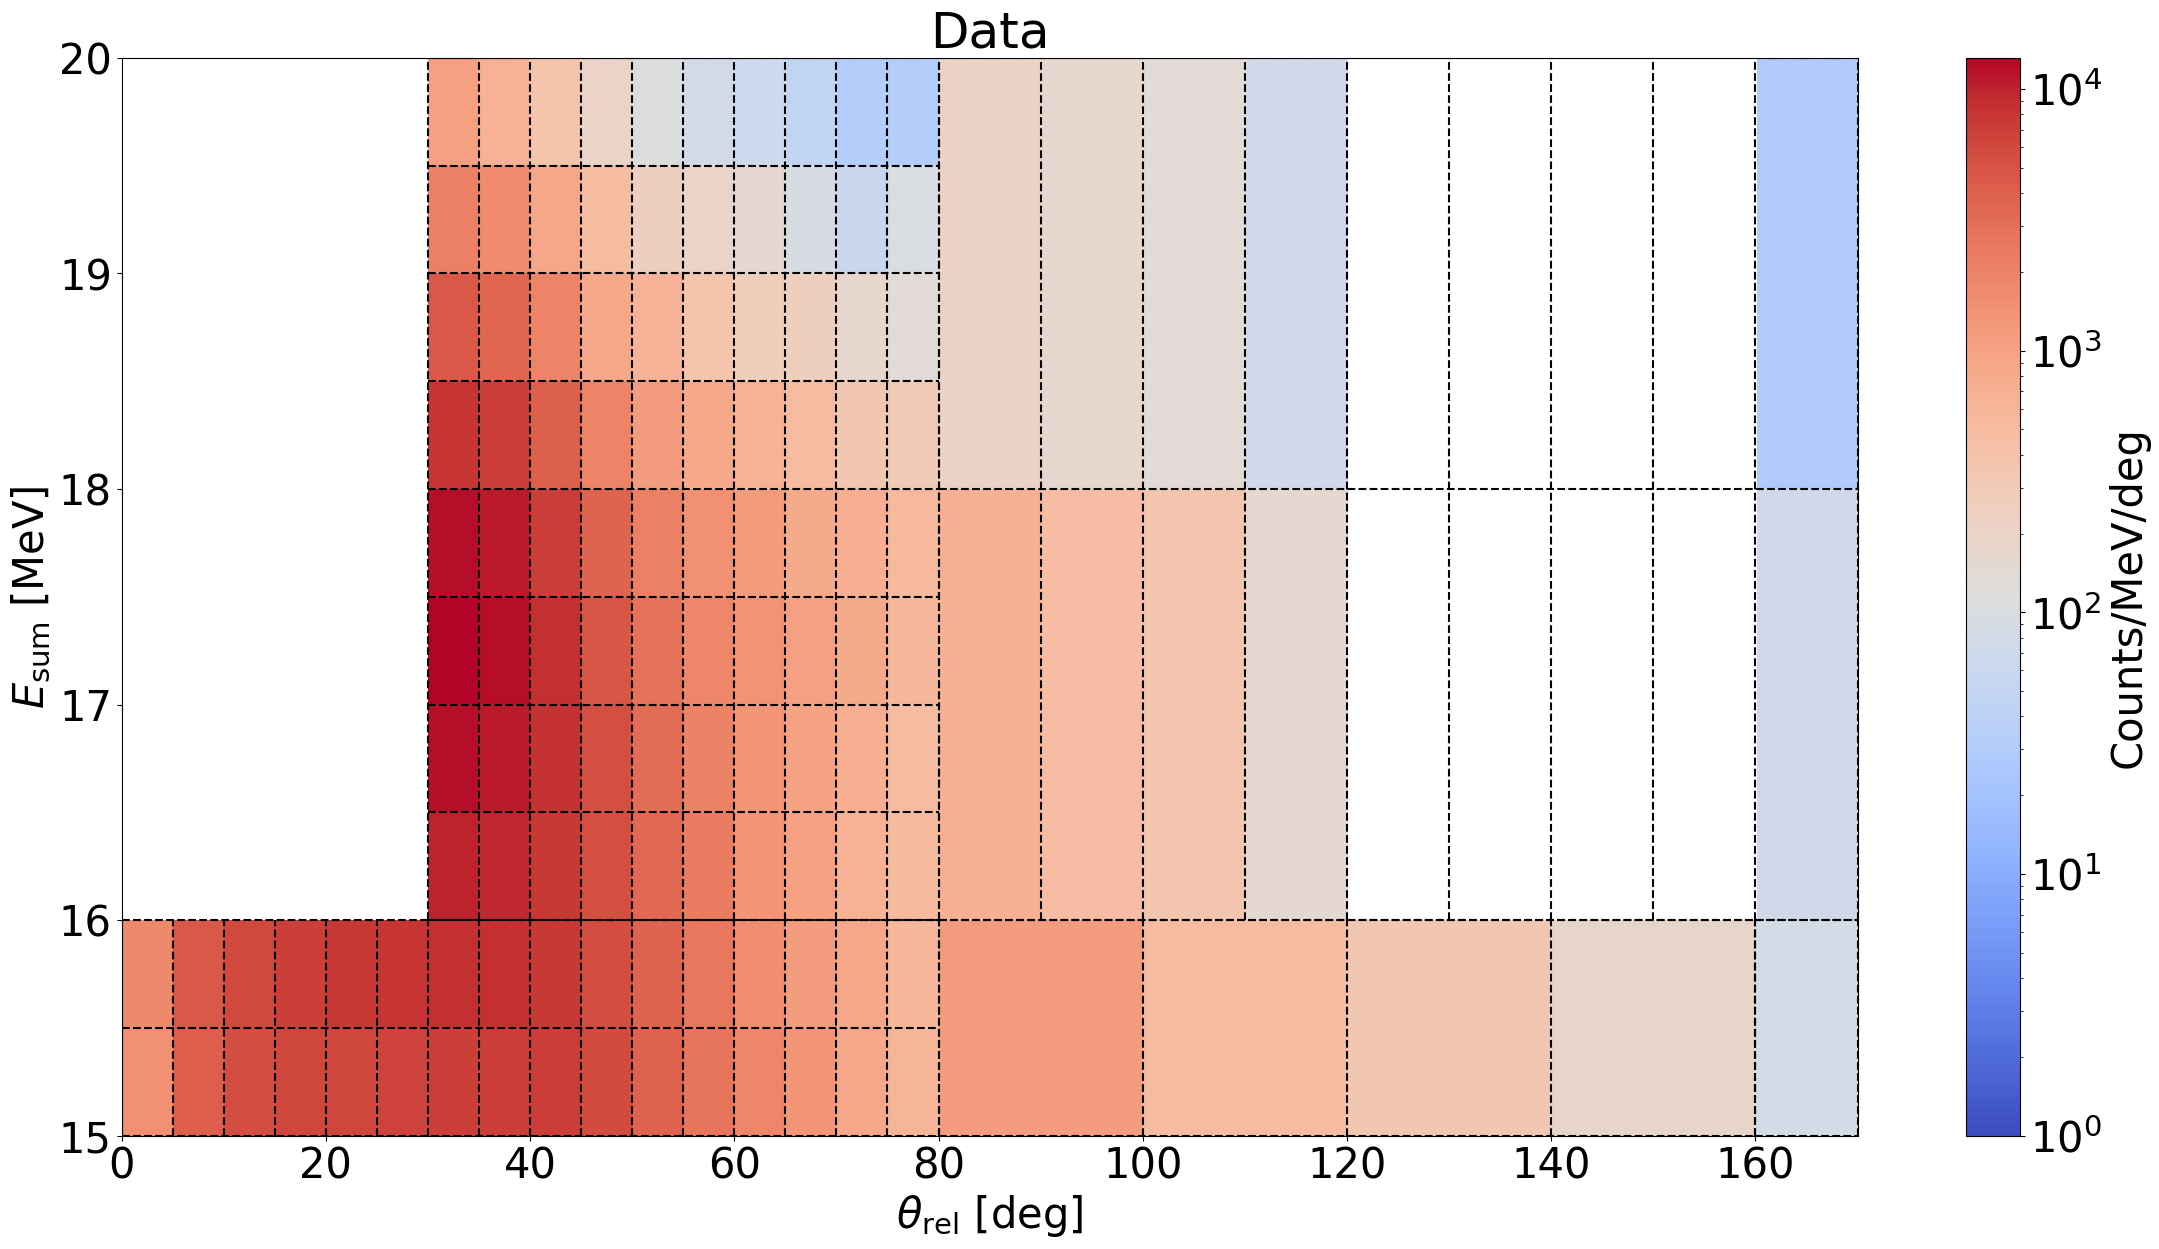

In [90]:
TotalDataNumber = 0
with uproot.open(workDir + dataFile + ':ntuple') as f:
    esum = f.arrays(['esum'], '(theta_gamma > 80) * (run < ' + str(dataRunMax) + ')', library='np')['esum']*1e3
    angle = f.arrays(['angle'], '(theta_gamma > 80) * (run < ' + str(dataRunMax) + ')', library='np')['angle']
    theta_gamma = f.arrays(['theta_gamma'], 'run < ' + str(dataRunMax), library='np')['theta_gamma']
    
    TotalDataNumber = len(theta_gamma)
    print('Total number of data events: ', TotalDataNumber)
    
    for channel in channels.keys():
        dataHist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])
        channels[channel]['dataHist'] = dataHist[0]
        channels[channel]['dataHistErr'] = np.sqrt(dataHist[0])

plotChannels(channels)

nData: 188860.0
nIPC 17.6 : 69322.0
nIPC 17.9 : 51211.0
nIPC 18.1 : 65252.0
nIPC 14.6 : 36371.0
nIPC 14.9 : 38505.0
nIPC 15.1 : 58215.0
nEPC 18 : 15986.0
nEPC 15 : 5717.0


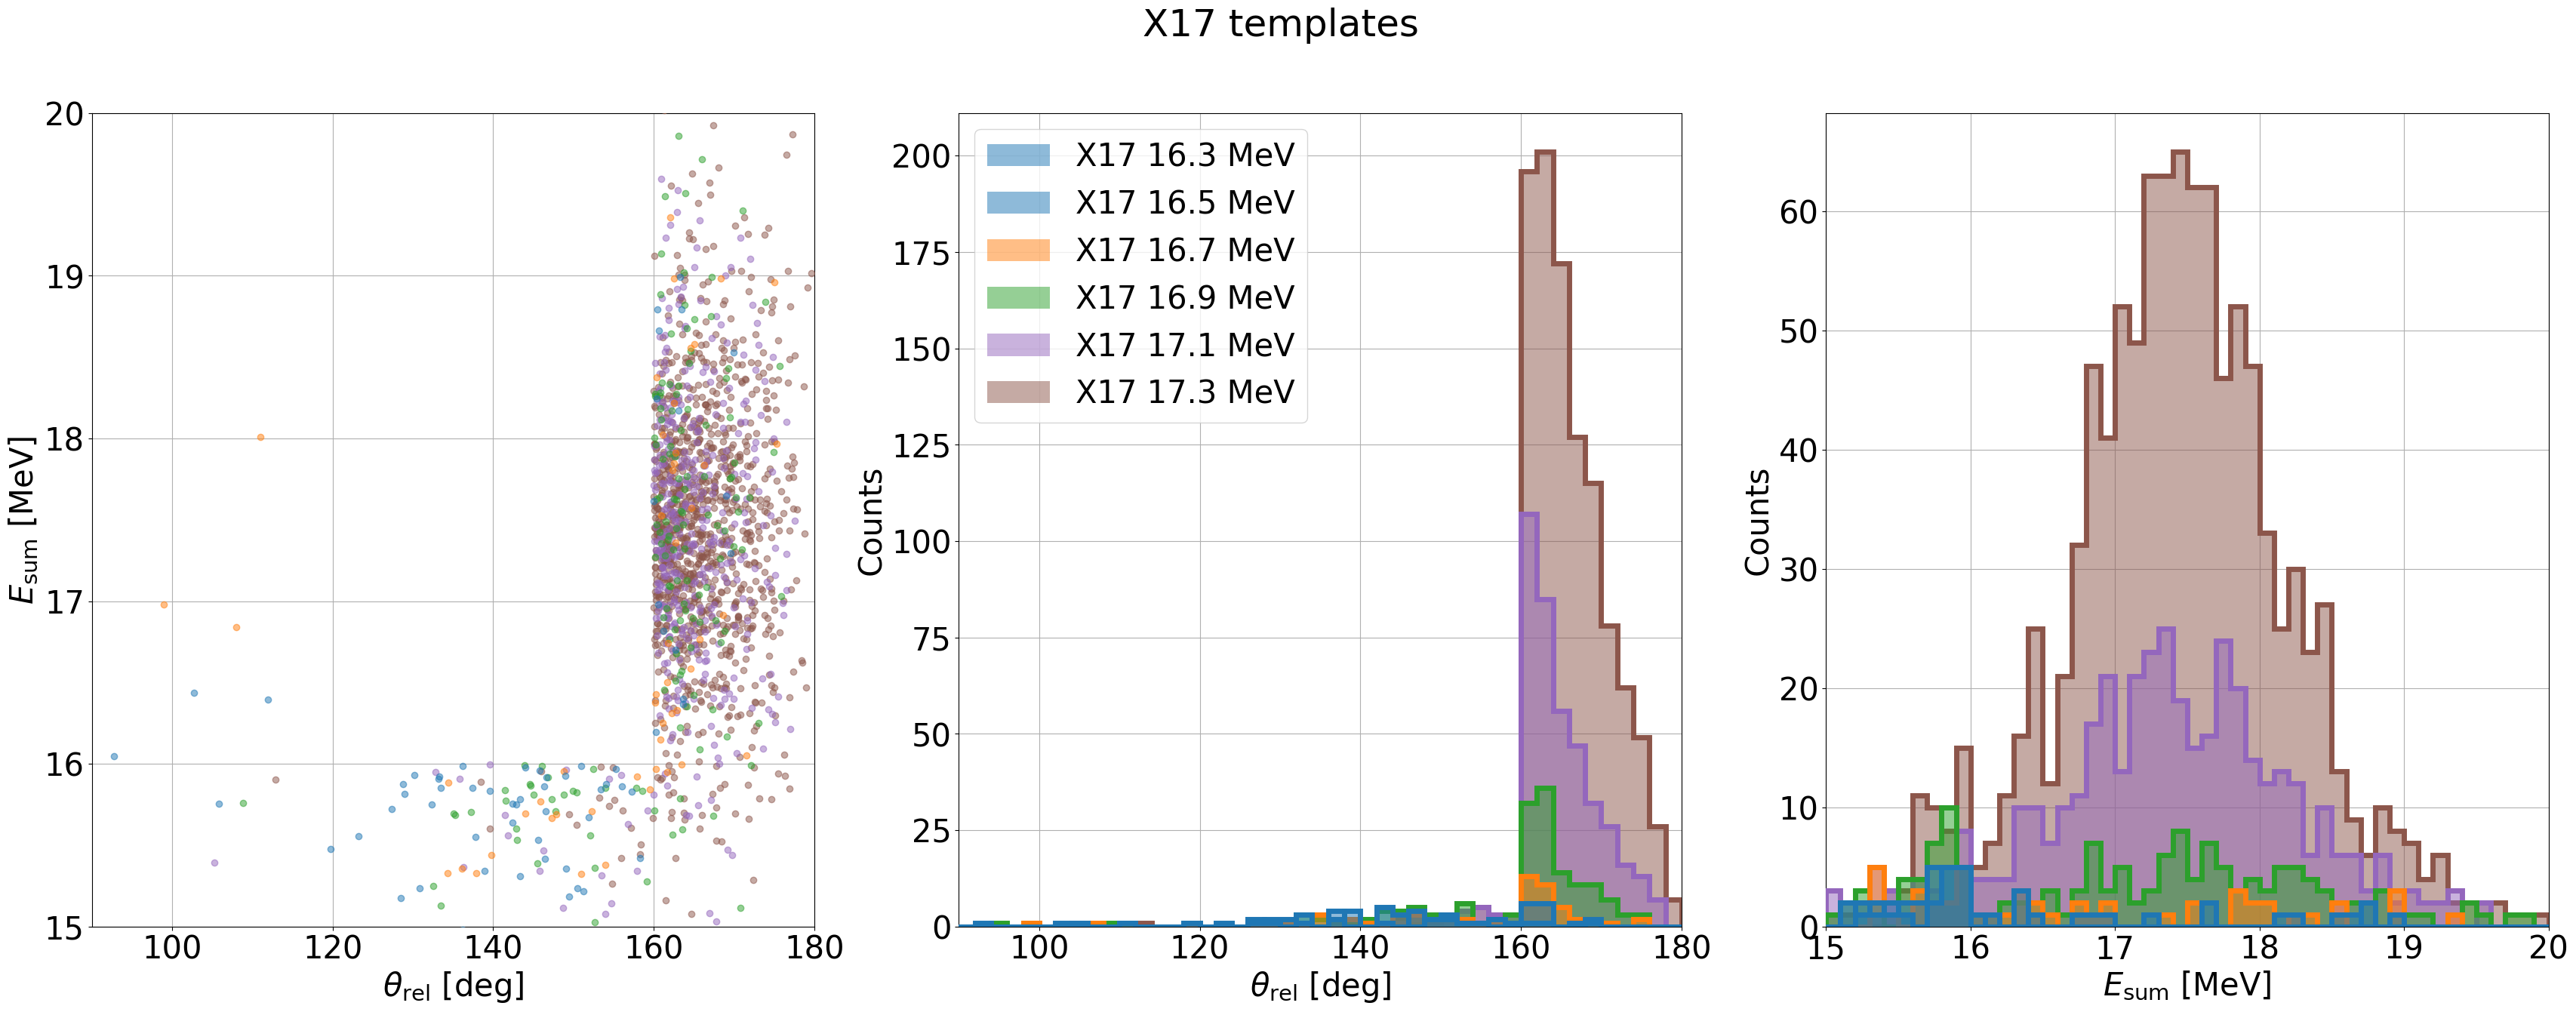

In [91]:
BKGnames = ['IPC 17.6', 'IPC 17.9', 'IPC 18.1', 'IPC 14.6', 'IPC 14.9', 'IPC 15.1', 'EPC 18', 'EPC 15']
alphaNames = ['res', 'field']

ECODETYPE = 'ecode' # alternative is ecode_bis
FixRes = True
FixField = False
FixRatios = False
ConstrainedRatios = True
ConstrainTotalData = False
AlternativeResolutionScale = True
MorphEPConly = False
drawMN = False
nToysForFit = 100

ratio176 = 3.84 # +- 0.27
ratio179 = 0.93 # +- 0.07
ratio181 = 0.74 # +- 0.06

dRatio176 = 0.27
dRatio179 = 0.07
dRatio181 = 0.06

p176 = ratio176/(ratio176 + 1)
dP176 = dRatio176/(ratio176 + 1)**2
p179 = ratio179/(ratio179 + 1)
dP179 = dRatio179/(ratio179 + 1)**2
p181 = ratio181/(ratio181 + 1)
dP181 = dRatio181/(ratio181 + 1)**2

TotalMCStatistics = []
TotalMCSignalStatistics = []

X17masses = np.array([16.3, 16.5, 16.7, 16.9, 17.1, 17.3])
dX17mass = 0.0001


# There is a problem with the first MC production and som paris are reconstructed multiple times, this function will remove duplicates
def removeDuplicates(MC):
    sort = np.argsort(MC['angle'])

    # Get indexes of repeated events
    repeated = np.where(np.diff(MC['angle'][sort]) == 0)[0]

    # Invert sorting on indexes to apply it to the original array
    repeated = sort[repeated]
    
    for key in MC.keys():
        MC[key] = np.delete(MC[key], repeated)
    return MC
    

with uproot.open('/Users/giovanni/PhD/Analysis/X17BBPythonTask/results/MC2023totOLDmerge.root:ntuple') as fCUT:
    MCCUT = fCUT.arrays([ECODETYPE, 'run', 'event'], library='np')
    
    ecodeCUT = MCCUT[ECODETYPE]
    runCUT = MCCUT['run']
    eventCUT = MCCUT['event']
        
    with uproot.open(workDir + MCFile + ':ntuple') as f:
        MC = f.arrays(['esum', 'angle', ECODETYPE, 'px_pos', 'py_pos', 'pz_pos', 'px_ele', 'py_ele', 'pz_ele', 'simpx_pos', 'simpy_pos', 'simpz_pos', 'simpx_ele', 'simpy_ele', 'simpz_ele', 'siminvm', 'run', 'event', 'theta_gamma'], library='np')
        
        MC = removeDuplicates(MC)
        
        # Select from MC only events in common with MCCUT
        selectionCUT = np.isin(MC['run'], runCUT) & np.isin(MC['event'], eventCUT)
        selectionCUT = selectionCUT | (MC[ECODETYPE] == 0)| (MC[ECODETYPE] == 1) | (MC[ECODETYPE] == 2) | (MC[ECODETYPE] == 3) | (MC[ECODETYPE] == 4) | (MC[ECODETYPE] == 5) | (MC[ECODETYPE] == 6) | (MC[ECODETYPE] == 7) | (MC[ECODETYPE] == 8)
        
        theta_gamma = MC['theta_gamma'][selectionCUT]
        
        alphaResCorrection = 1
        if MorphEPConly:
            alphaFieldCorrection = 1
        else:
            alphaFieldCorrection = 0.152/0.1537
        
        
        # Get TotalMCStatistics
        ecode = MC[ECODETYPE]
        
        for i in range(1, 9):
            TotalMCStatistics.append(np.sum(ecode == i))
        
        _ecode = MC[ECODETYPE][selectionCUT]
        _esum = MC['esum'][selectionCUT]*1e3*alphaFieldCorrection
        _angle = MC['angle'][selectionCUT]
        _px_pos = MC['px_pos'][selectionCUT]*alphaFieldCorrection
        _py_pos = MC['py_pos'][selectionCUT]*alphaFieldCorrection
        _pz_pos = MC['pz_pos'][selectionCUT]*alphaFieldCorrection
        _px_ele = MC['px_ele'][selectionCUT]*alphaFieldCorrection
        _py_ele = MC['py_ele'][selectionCUT]*alphaFieldCorrection
        _pz_ele = MC['pz_ele'][selectionCUT]*alphaFieldCorrection
        _simpx_pos = MC['simpx_pos'][selectionCUT]*alphaFieldCorrection
        _simpy_pos = MC['simpy_pos'][selectionCUT]*alphaFieldCorrection
        _simpz_pos = MC['simpz_pos'][selectionCUT]*alphaFieldCorrection
        _simpx_ele = MC['simpx_ele'][selectionCUT]*alphaFieldCorrection
        _simpy_ele = MC['simpy_ele'][selectionCUT]*alphaFieldCorrection
        _simpz_ele = MC['simpz_ele'][selectionCUT]*alphaFieldCorrection
        _siminvm = MC['siminvm'][selectionCUT]
        
        _px_pos = _simpx_pos + (alphaResCorrection)*(_px_pos - _simpx_pos)
        _py_pos = _simpy_pos + (alphaResCorrection)*(_py_pos - _simpy_pos)
        _pz_pos = _simpz_pos + (alphaResCorrection)*(_pz_pos - _simpz_pos)
        _px_ele = _simpx_ele + (alphaResCorrection)*(_px_ele - _simpx_ele)
        _py_ele = _simpy_ele + (alphaResCorrection)*(_py_ele - _simpy_ele)
        _pz_ele = _simpz_ele + (alphaResCorrection)*(_pz_ele - _simpz_ele)
        
        if MorphEPConly:
            _esum[(_ecode == 7) | (_ecode == 8)] = _esum[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _px_pos[(_ecode == 7) | (_ecode == 8)] = _px_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _py_pos[(_ecode == 7) | (_ecode == 8)] = _py_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _pz_pos[(_ecode == 7) | (_ecode == 8)] = _pz_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _px_ele[(_ecode == 7) | (_ecode == 8)] = _px_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _py_ele[(_ecode == 7) | (_ecode == 8)] = _py_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _pz_ele[(_ecode == 7) | (_ecode == 8)] = _pz_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpx_pos[(_ecode == 7) | (_ecode == 8)] = _simpx_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpy_pos[(_ecode == 7) | (_ecode == 8)] = _simpy_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpz_pos[(_ecode == 7) | (_ecode == 8)] = _simpz_pos[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpx_ele[(_ecode == 7) | (_ecode == 8)] = _simpx_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpy_ele[(_ecode == 7) | (_ecode == 8)] = _simpy_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
            _simpz_ele[(_ecode == 7) | (_ecode == 8)] = _simpz_ele[(_ecode == 7) | (_ecode == 8)]*0.152/0.1537
        
        _ecode = _ecode[theta_gamma > 80]
        _esum = _esum[theta_gamma > 80]
        _angle = _angle[theta_gamma > 80]
        _px_pos = _px_pos[theta_gamma > 80]
        _py_pos = _py_pos[theta_gamma > 80]
        _pz_pos = _pz_pos[theta_gamma > 80]
        _px_ele = _px_ele[theta_gamma > 80]
        _py_ele = _py_ele[theta_gamma > 80]
        _pz_ele = _pz_ele[theta_gamma > 80]
        _simpx_pos = _simpx_pos[theta_gamma > 80]
        _simpy_pos = _simpy_pos[theta_gamma > 80]
        _simpz_pos = _simpz_pos[theta_gamma > 80]
        _simpx_ele = _simpx_ele[theta_gamma > 80]
        _simpy_ele = _simpy_ele[theta_gamma > 80]
        _simpz_ele = _simpz_ele[theta_gamma > 80]
        _siminvm = _siminvm[theta_gamma > 80]*1e3
        
        # Get Signal
        # Loop over masses
        fig = plt.figure(figsize=(42, 14), dpi=100)
        for mass in X17masses:
            esum = _esum[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)]
            angle = _angle[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)]
            p = np.vstack((_px_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _py_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _pz_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _px_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _py_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _pz_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)]))*1e3
            simp = np.vstack((_simpx_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _simpy_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _simpz_pos[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _simpx_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _simpy_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)], _simpz_ele[(_ecode == 0)*(np.abs(_siminvm - mass) < dX17mass)]))*1e3
            
            # Select mass
            selection = (esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)
            esum = esum[selection]
            angle = angle[selection]
            
            esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, alphares, alphafield, AlternativeResolutionScale = False)
            
            plt.subplot(1, 3, 1)
            plt.plot(angle, esum, 'o', label='X17 %.1f MeV' %(mass), alpha=0.5, color='C' + str(int((mass - 16.3)/0.2)), zorder=20 - int((mass - 16.3)/0.2))
            
            plt.subplot(1, 3, 2)
            plt.hist(angle, bins=90, range=[0, 180], alpha = 0.5, label='X17 %.1f MeV' %(mass), color='C' + str(int((mass - 16.3)/0.2)), zorder=20 - int((mass - 16.3)/0.2))
            plt.hist(angle, bins=90, range=[0, 180], histtype='step', color='C' + str(int((mass - 16.3)/0.2)), zorder=20 - int((mass - 16.3)/0.2), linewidth=5)
            
            plt.subplot(1, 3, 3)
            plt.hist(esum, bins=50, range=[15, 20], alpha = 0.5, label='X17 %.1f MeV' %(mass), color='C' + str(int((mass - 16.3)/0.2)), zorder=20 - int((mass - 16.3)/0.2))
            plt.hist(esum, bins=50, range=[15, 20], histtype='step', label='X17 %.1f MeV' %(mass), color='C' + str(int((mass - 16.3)/0.2)), zorder=20 - int((mass - 16.3)/0.2), linewidth=5)
            
            for channel in channels.keys():
                hist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]
        
                channels[channel]['X17%.1f' %(mass)] = np.copy(hist)
                
                for j in range(1, 6):
                    esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, j*alphares, j*alphafield, AlternativeResolutionScale = False)
                    histres_up = np.histogram2d(esumres_up, angleres_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]
                    histres_dn = np.histogram2d(esumres_dn, angleres_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]
                    histfield_up = np.histogram2d(esumfield_up, anglefield_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]
                    histfield_dn = np.histogram2d(esumfield_dn, anglefield_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]
                    channels[channel]['X17%.1fres_%dup' %(mass, j)] = np.copy(histres_up)
                    channels[channel]['X17%.1fres_%ddn' %(mass, j)] = np.copy(histres_dn)
                    channels[channel]['X17%.1ffield_%dup' %(mass, j)] = np.copy(histfield_up)
                    channels[channel]['X17%.1ffield_%ddn' %(mass, j)] = np.copy(histfield_dn)
                    
                channels[channel]['X17%.1fres_up' %(mass)] = np.copy(channels[channel]['X17%.1fres_1up' %(mass)])
                channels[channel]['X17%.1fres_dn' %(mass)] = np.copy(channels[channel]['X17%.1fres_1dn' %(mass)])
                channels[channel]['X17%.1ffield_up' %(mass)] = np.copy(channels[channel]['X17%.1ffield_1up' %(mass)])
                channels[channel]['X17%.1ffield_dn' %(mass)] = np.copy(channels[channel]['X17%.1ffield_1dn' %(mass)])
        
        plt.suptitle('X17 templates')
        plt.subplot(1, 3, 1)
        plt.grid()
        plt.ylabel(r'$E_{\mathrm{sum}}$ [MeV]')
        plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
        plt.xlim(90, 180)
        plt.ylim(15, 20)
        
        plt.subplot(1, 3, 2)
        plt.grid()
        plt.legend()
        plt.ylabel('Counts')
        plt.xlabel(r'$\theta_{\mathrm{rel}}$ [deg]')
        plt.xlim(90, 180)
        
        plt.subplot(1, 3, 3)
        plt.grid()
        plt.ylabel('Counts')
        plt.xlabel(r'$E_{\mathrm{sum}}$ [MeV]')
        plt.xlim(15, 20)
        
        # Get Backgrounds
        for i in range(1, 9): # running on ecode
            esum = _esum[_ecode == i]
            angle = _angle[_ecode == i]
            
            selection = (esum < esumCutLow) | (esum > esumCutHigh) | (angle < angleCutLow) | (angle > angleCutHigh)
            esum = esum[selection]
            angle = angle[selection]
            p = np.vstack((_px_pos[_ecode == i], _py_pos[_ecode == i], _pz_pos[_ecode == i], _px_ele[_ecode == i], _py_ele[_ecode == i], _pz_ele[_ecode == i]))*1e3
            simp = np.vstack((_simpx_pos[_ecode == i], _simpy_pos[_ecode == i], _simpz_pos[_ecode == i], _simpx_ele[_ecode == i], _simpy_ele[_ecode == i], _simpz_ele[_ecode == i]))*1e3
                
            if i < 7:
                esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, alphares, alphafield, AlternativeResolutionScale = False)
            else:
                esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, alphares, alphafield, AlternativeResolutionScale = AlternativeResolutionScale)
            
            factor = 1
            for channel in channels.keys():
                hist = np.histogram2d(esum, angle, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                
                channels[channel][BKGnames[i-1]] = np.copy(hist)
                
                for j in range(1, 6):
                    if i < 7:
                        esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, j*alphares, j*alphafield, AlternativeResolutionScale = False)
                    else:
                        esumres_up, angleres_up, esumres_dn, angleres_dn, esumfield_up, anglefield_up, esumfield_dn, anglefield_dn = createUpDownVariables(p, simp, j*alphares, j*alphafield, AlternativeResolutionScale = AlternativeResolutionScale)
                    
                    if i < 7 and MorphEPConly:
                        histres_up = np.copy(hist)
                        histres_dn = np.copy(hist)
                        histfield_up = np.copy(hist)
                        histfield_dn = np.copy(hist)
                    else:
                        histres_up = np.histogram2d(esumres_up, angleres_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                        histres_dn = np.histogram2d(esumres_dn, angleres_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                        histfield_up = np.histogram2d(esumfield_up, anglefield_up, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                        histfield_dn = np.histogram2d(esumfield_dn, anglefield_dn, bins=[channels[channel]['Esum'][2], channels[channel]['Angle'][2]], range=[channels[channel]['Esum'][:2], channels[channel]['Angle'][:2]])[0]*factor
                    channels[channel][BKGnames[i-1] + 'res_%dup' %(j)] = np.copy(histres_up)
                    channels[channel][BKGnames[i-1] + 'res_%ddn' %(j)] = np.copy(histres_dn)
                    channels[channel][BKGnames[i-1] + 'field_%dup' %(j)] = np.copy(histfield_up)
                    channels[channel][BKGnames[i-1] + 'field_%ddn' %(j)] = np.copy(histfield_dn)
                    
                channels[channel][BKGnames[i-1] + 'res_up'] = np.copy(channels[channel][BKGnames[i-1] + 'res_1up'])
                channels[channel][BKGnames[i-1] + 'res_dn'] = np.copy(channels[channel][BKGnames[i-1] + 'res_1dn'])
                channels[channel][BKGnames[i-1] + 'field_up'] = np.copy(channels[channel][BKGnames[i-1] + 'field_1up'])
                channels[channel][BKGnames[i-1] + 'field_dn'] = np.copy(channels[channel][BKGnames[i-1] + 'field_1dn'])
            
            samples = [BKGnames[i-1], BKGnames[i-1] + 'res_up', BKGnames[i-1] + 'res_dn', BKGnames[i-1] + 'field_up', BKGnames[i-1] + 'field_dn']
            #plotChannels(channels, sample=samples, title=BKGnames[i-1])
                
    print('nData:', np.sum([channels[channel]['dataHist'].sum() for channel in channels.keys()]))
    nBKGs = {}
    for i in range(1, 9):
        nBKGs[BKGnames[i-1]] = np.sum([channels[channel][BKGnames[i-1]].sum() for channel in channels.keys()])
        print('n' + BKGnames[i-1], ':', nBKGs[BKGnames[i-1]])

## Histograms initialization

(6, 2, 11, 135)
(6, 11, 135)
(6, 135)
(6, 135)
(6, 2, 11, 135)
(6, 2, 11, 135)
(2, 8, 11, 135)


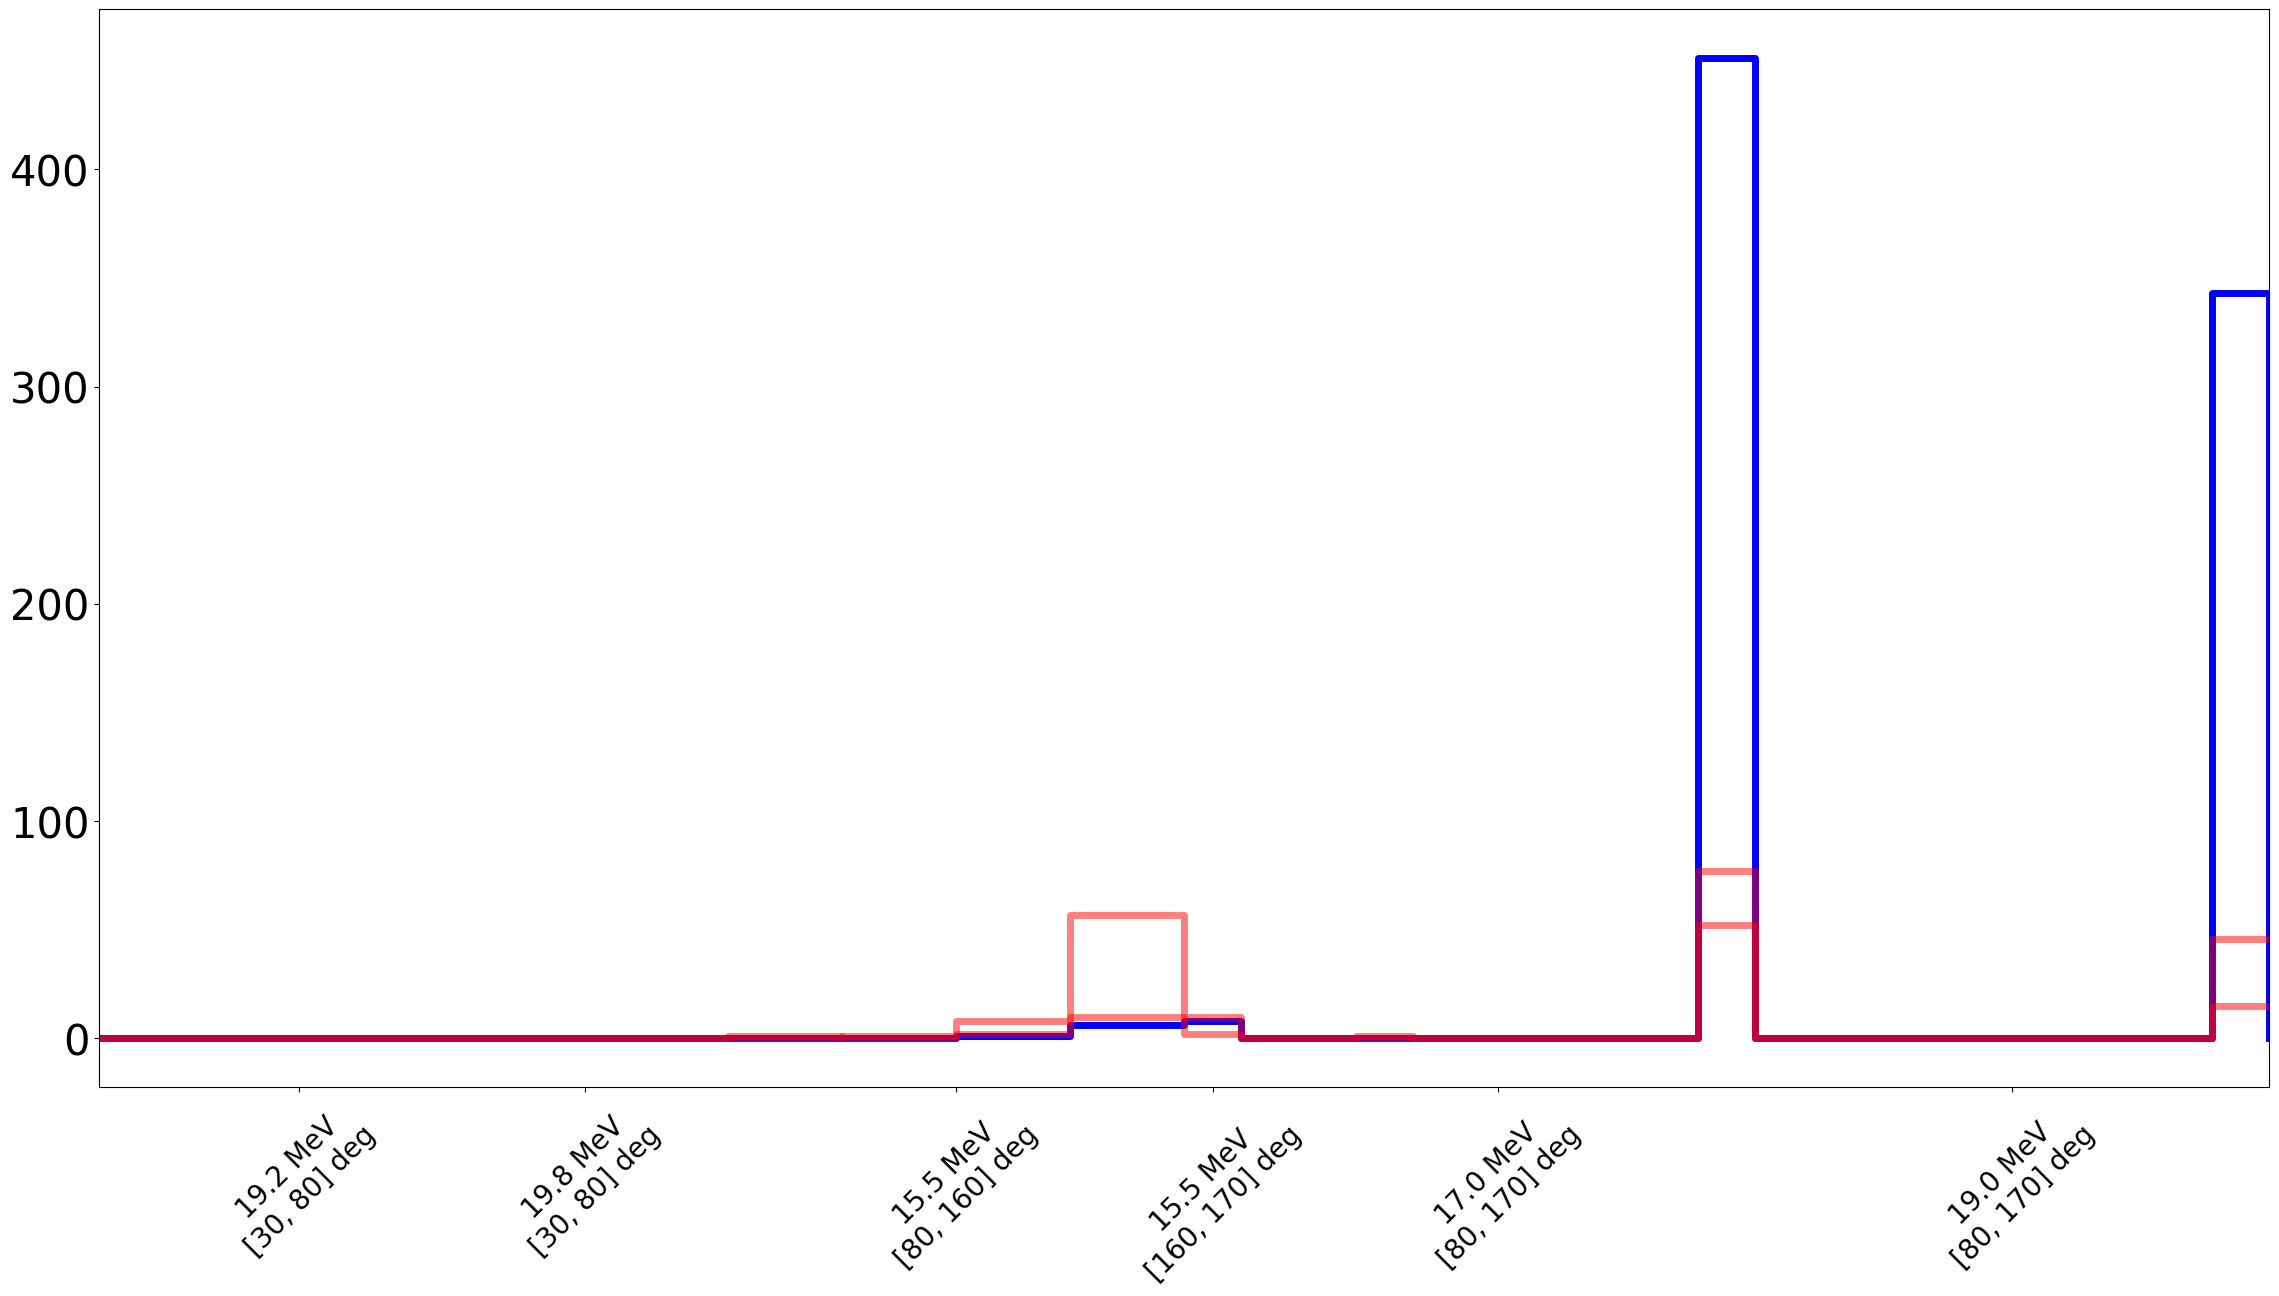

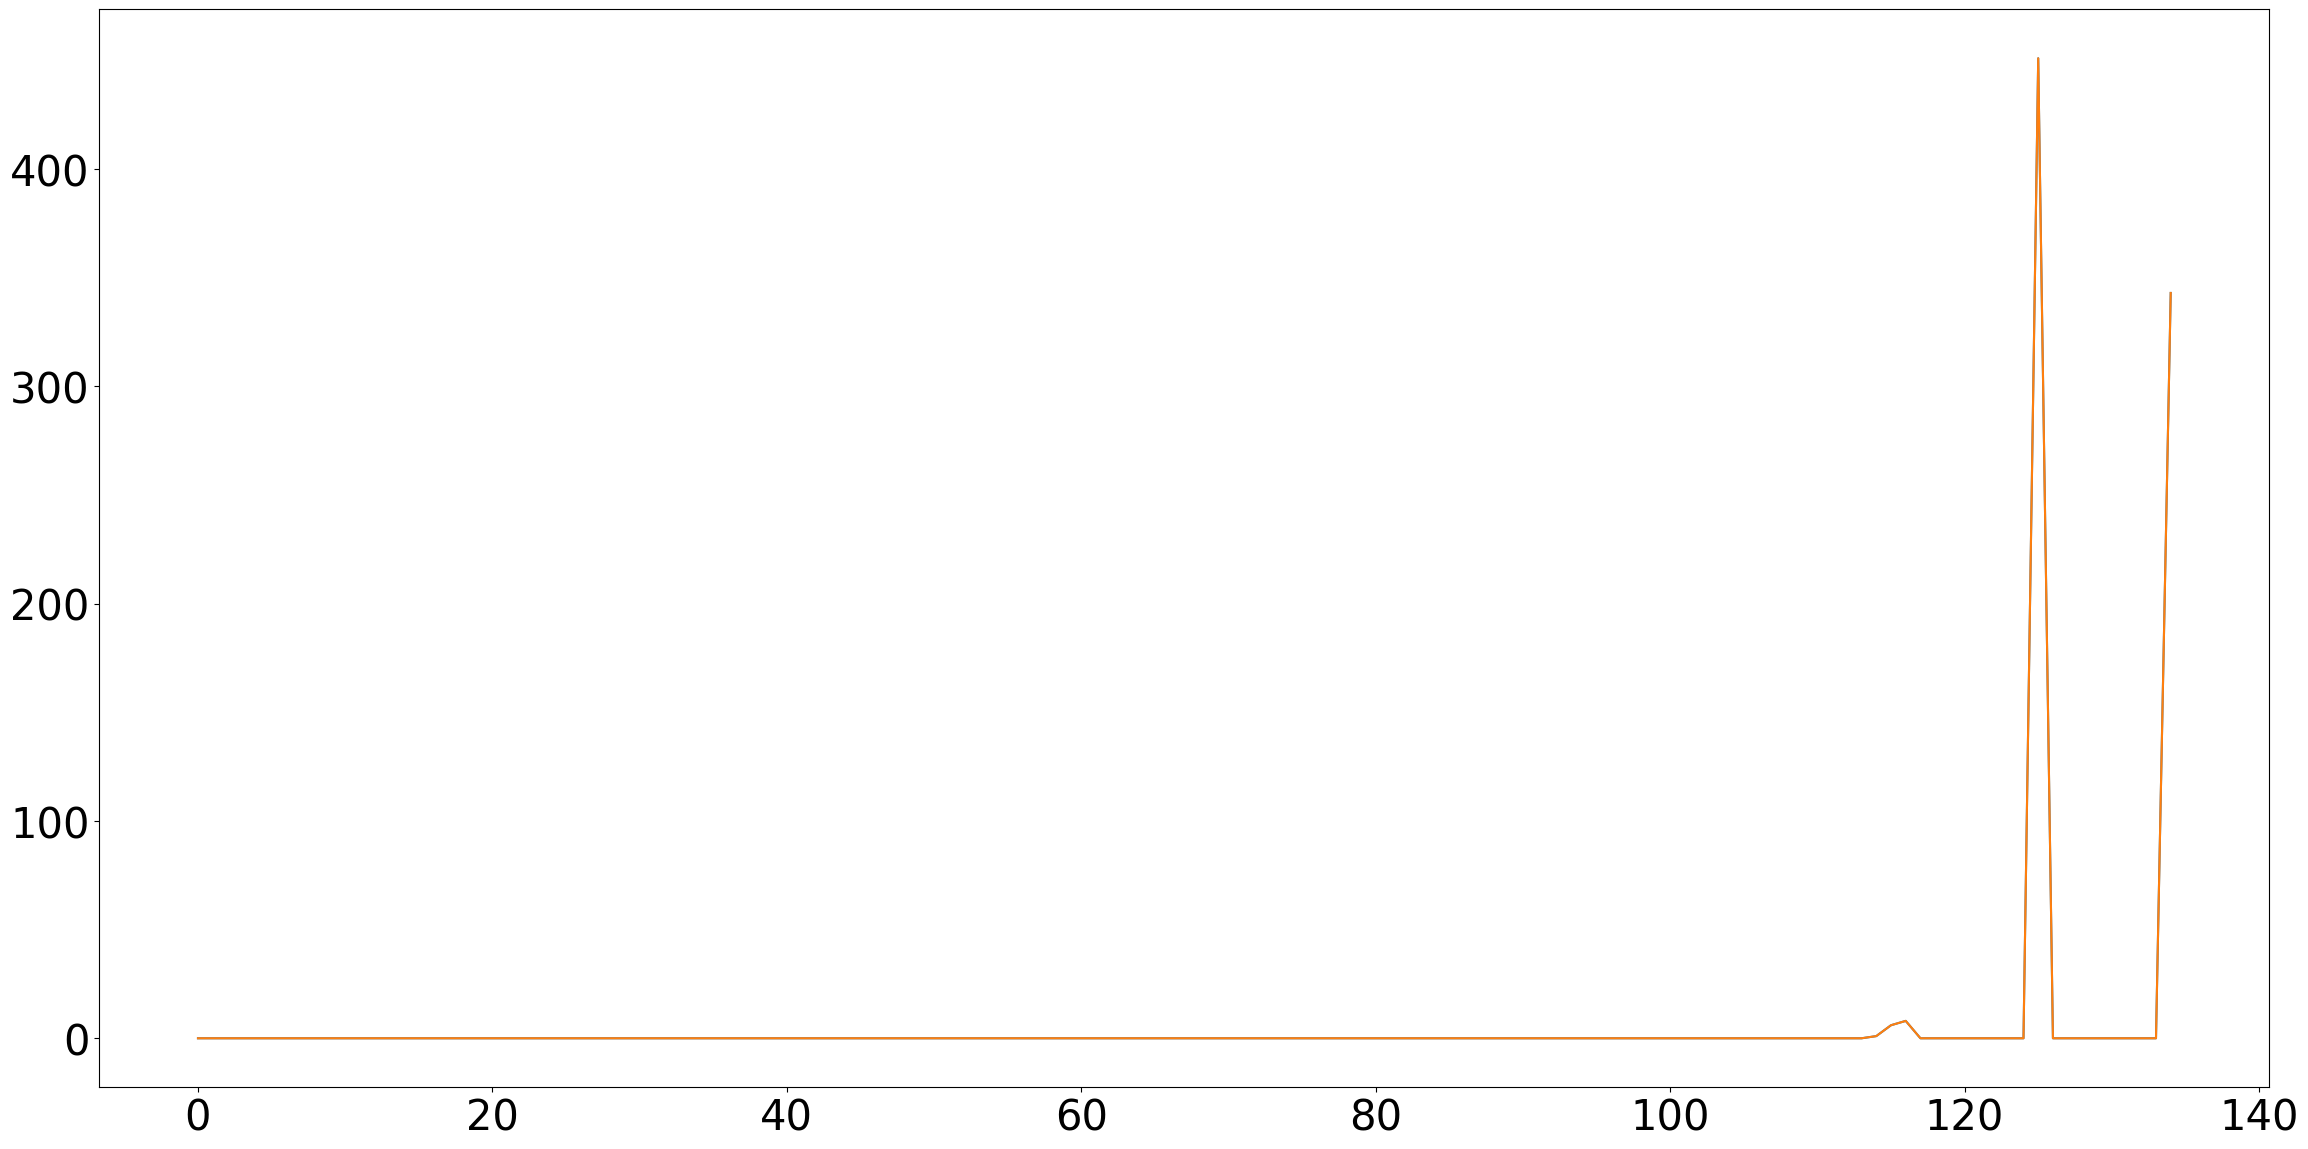

In [92]:
alphavalues = [np.linspace(-5*alphares, 5*alphares, 11), np.linspace(-5*alphafield, 5*alphafield, 11)]
alphaRefs = [0, 0]
Hists = histHandler(channels, 'dataHist', 'X17', BKGnames, 'Esum', 'Angle', alphaNames, alphavalues, alphaRefs, TotalMCStatistics=np.array(TotalMCStatistics), masses=X17masses, massRef=16.9)


yields = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])

MASS = 17.3

binWidths = np.array(combinedBins(Hists.channels))
binSides = [np.sum(binWidths[:i]) for i in range(len(binWidths))]
binSides.append(np.sum(binWidths))
fig = plt.figure(figsize=(28, 14), dpi=100)

plt.step(binSides, np.append(Hists.getEstimate(yields, morph = [0.0,0.025], mass = MASS, multiplier=True), Hists.getEstimate(yields, morph = [0,0], mass = MASS)[-1]), where='post',color = 'b', linewidth=5, label= 'Interpolated mass = %.1f MeV/c$^2$' %MASS)

temp = Hists.SignalArrayNuisance5Sigma[3, 1, 0]
plt.step(binSides, np.append(temp, temp[-1]), where='post', alpha=0.5, linewidth=5, label=r'Mass = 16.3 MeV/c$^2$', color='red')

temp = Hists.SignalArrayNuisance5Sigma[3, 1, 10]
plt.step(binSides, np.append(temp, temp[-1]), where='post', alpha=0.5, linewidth=5, label=r'Mass = 16.3 MeV/c$^2$', color='red')

print(Hists.SignalArrayNuisance5SigmaArray.shape)
print(Hists.SignalArrayNuisance5SigmaToy[:, 0, :, :].shape)
# Plot a vertical line to separate the Esum bins
index = 0
xticks = []
xtickslabels = []
for channel in Hists.channels.keys():
    esumBins = np.linspace(Hists.channels[channel]['Esum'][0], Hists.channels[channel]['Esum'][1], Hists.channels[channel]['Esum'][2]+1)
    esumBins = (esumBins[1:] + esumBins[:-1])/2
    minAngle = Hists.channels[channel]['Angle'][0]
    maxAngle = Hists.channels[channel]['Angle'][1]
    for esum in esumBins:
        index = index + Hists.channels[channel]['Angle'][2]
        #plt.vlines(binSides[index], 0, 1e5, colors='k', linestyles='dashed')
        # Text inside the box
        xticks.append(0.5*(binSides[index] + binSides[index-Hists.channels[channel]['Angle'][2]]))
        xtickslabels.append(f'{esum:.1f} MeV\n[{minAngle}, {maxAngle}] deg')
#plt.yscale('log')
plt.gca().set_xticks(xticks)
plt.gca().set_xticklabels(xtickslabels, fontsize=20)
plt.xticks(rotation=45)
#plt.ylim(0, 20)
plt.xlim(450, binSides[-1])


fig = plt.figure(figsize=(28, 14), dpi=100)
plt.plot(Hists.getEstimate(yields, morph = [0.0,0.025], mass = MASS, multiplier=True))
plt.plot(Hists.getEstimateVariance(yields, morph = [0.0,0.025], mass = MASS, multiplier=True))


#for i in range(9):
#    fig = plt.figure(figsize=(28, 14), dpi=100)
#    yields = np.zeros(9)
#    yields[i] = 100000
#    #yields[i] = 1
#    if i == 0:
#        plt.title('Signal')
#    else:
#        plt.title(BKGnames[i-1])
#    for i in range(100):
#        Hists.generateToy(yields, betas = 1, nus = 1, fluctuateTemplates=True, morph = [0.0, 0.025], mass = MASS)
#        #plt.step(binSides[:-1], Hists.getEstimateToy(yields, morph = [0.0,0.025], mass = MASS, multiplier=True) - Hists.getEstimateVarianceToy(yields, morph = [0.0,0.025], mass = MASS, multiplier=True), linewidth=5)
#        #plt.step(binSides[:-1], Hists.getEstimateToy(yields, morph = [0.0,0.], mass = MASS, multiplier=True) - np.power(Hists.getEstimateUncertaintyToy(yields, morph = [0.0,0.0], mass = MASS, multiplier=True), 2), linewidth=5)
#        #plt.step(binSides[:-1], Hists.getEstimateToy(yields, morph = [0.0,0.025], mass = MASS))
#        plt.step(binSides[:-1], Hists.DataArrayToy, linewidth=5)
#
#    plt.step(binSides[:-1], Hists.getEstimate(yields, morph = [0.0,0.025], mass = MASS), linewidth=5, color='r')
#    plt.xlim(450, binSides[-1])

print(Hists.SignalArray.shape)
print(Hists.SignalArrayToy.shape)
print(Hists.SignalArrayNuisance5Sigma.shape)
print(Hists.SignalArrayNuisance5SigmaToy.shape)
print(Hists.BKGarrayNuisance5SigmaToy.shape)

# Likelihood and fitter functions

Here the likelihood and a number of utility functions to find the best likelihood and evaluate the fit are defined.

## Likelihood and fitter functions

In [123]:
# Nuisances
# Sampled PDF centers
_p176 = p176
_p179 = p179
_p181 = p181
_alphaField = 0

# Best fit values
newP176 = p176
newP179 = p179
newP181 = p181
newAlphaField = 0

# Field scale Fomr Hicham
OldScale = 0.152
NewScale = 0.1537
dNewScale = 0.0002

Correction = OldScale/NewScale
dCorrection = dNewScale*OldScale/NewScale**2

dAlphaField = dCorrection

# Best Likelihood
MAXLikelihood = 0

def getYields(nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15):
    
    nIPC176 =  nIPC400*percent176
    nIPC179 =  nIPC700*percent179
    nIPC181 = nIPC1000*percent181
    
    nIPC146 = nIPC400*(FIPC15)* (1 - percent176)
    nIPC149 = nIPC700*(FIPC15)* (1 - percent179)
    nIPC151 = nIPC1000*(FIPC15)*(1 - percent181)
    
    return np.array([nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151])

# Full log Likelihood calculation
# The returned value is the Baker-Cousins ratio
def ll(Di, fPar = 0, mu = 0, mueff = 0, betas = 1, alphas = 0, P = 0):
    f = mu + fPar
    binnedTerm = Di*np.log(f + (f == 0)) - f - Di*np.log(Di + (Di == 0)) + Di
    binnedTerm = binnedTerm + mueff*(np.log(betas) - (betas - 1))
    binnedTerm = -2*np.sum(binnedTerm)
    return binnedTerm + np.sum(np.power(alphas, 2)) + P

def logLikelihood(pars, doBB = True, FitToy = False, doNullHypothesis = False, _p176 = p176, _p179 = p179, _p181 = p181, _alphaField = 0):
    # Prepare yields vector
    nSig, mass, nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15, nEPC18, nEPC15, alphaRes, alphaField = pars
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151 = getYields(nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15)
    yields = np.array([nSig, nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    if doNullHypothesis:
        mass = None
        yields = yields[1:]
    
    # Compute penalty term for nuisances
    P = 0
    P += np.power((percent176 - _p176)/dP176, 2)
    P += np.power((percent179 - _p179)/dP179, 2)
    P += np.power((percent181 - _p181)/dP181, 2)
    P += np.power((alphaField - _alphaField)/dAlphaField, 2)

    # Compute statistical uncertainty
    if FitToy:
        estimateVarianceFunction = Hists.getEstimateVarianceToy
        estimateFunction = Hists.getEstimateToy
        data = Hists.DataArrayToy
    else:
        estimateVarianceFunction = Hists.getEstimateVariance
        estimateFunction = Hists.getEstimate
        data = Hists.DataArray
    
    mu0 = estimateFunction(yields, betas = 1, morph = [alphaRes, alphaField], mass = mass)
    if doBB:
        Vmu0 = estimateVarianceFunction(yields, betas = 1, morph = [alphaRes, alphaField], mass = mass)
        mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
        betas = BBliteBeta(data, mu0, mueff)
        mu = estimateFunction(yields, betas, morph = [alphaRes, alphaField], mass = mass)
    else:
        mueff = 0
        betas = 1
        mu = mu0
        
    return ll(data, mu = mu, mueff = mueff, betas = betas, P=P)

def logLSetLimits(logL):
    # Set limits
    # Signal
    logL.limits[0] = (0, 1000)
    logL.limits[1] = (16.5, 17.3)
    
    # IPC
    # Yields
    logL.limits[2] = (0, None)
    logL.limits[3] = (0, None)
    logL.limits[4] = (0, None)
    
    # Percentages
    logL.limits[5] = (0, 1)
    logL.limits[6] = (0, 1)
    logL.limits[7] = (0, 1)
    
    # IPC 15 acceptance
    logL.limits[8] = (0, 10)
    
    # EPC yields
    logL.limits[9] = (0, None)
    logL.limits[10] = (0, None)
    
    # Scales
    logL.limits[11] = (alphavalues[0][0], alphavalues[0][-1])
    logL.limits[12] = (alphavalues[1][0], alphavalues[1][-1])
    return logL

# This function finds the best parameters
def bestFit(startingPars, FitToy = False, doNullHypothesis = False, FixedParameters = False, _p176 = p176, _p179 = p179, _p181 = p181, _alphaField = 0):
    # First, find the best fit with doBB = False
    # Then, minimize for each parameter independently twice
    # Finally, minimize the full log likelihood
    
    ############################################
    # Find suitable starting point
    def lambdaLikelihood(pars):
        return logLikelihood(pars, doBB = False, FitToy = FitToy, doNullHypothesis = doNullHypothesis, _p176 = _p176, _p179 = _p179, _p181 = _p181, _alphaField = _alphaField)
    
    # Define minuit
    names = ['nSig', 'mass', 'nIPC400', 'nIPC700', 'nIPC1000', 'percent176', 'percent179', 'percent181', 'FIPC15', 'nEPC18', 'nEPC15', 'alphaRes', 'alphaField']
    logL = Minuit(lambdaLikelihood, startingPars, name = names)
    
    # Set limits
    logL = logLSetLimits(logL)
    
    # Fix parameters
    if isinstance(FixedParameters, list) or isinstance(FixedParameters, np.ndarray):
        logL.fixed = FixedParameters
    
    if doNullHypothesis:
        logL.values[0] = 0
        logL.fixed[0] = True
        logL.fixed[1] = True
    
    logL.simplex(ncall = 100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall = 100000, iterate = 5)
    
    startingPars = logL.values
    
    ############################################
    # Find best fit
    def lambdaLikelihood(pars):
        return logLikelihood(pars, doBB = True, FitToy = FitToy, doNullHypothesis = doNullHypothesis, _p176 = _p176, _p179 = _p179, _p181 = _p181, _alphaField = _alphaField)
    logL = Minuit(lambdaLikelihood, startingPars, name = names)
    
    # Set limits
    logL = logLSetLimits(logL)
    
    # Fix parameters
    if isinstance(FixedParameters, list) or isinstance(FixedParameters, np.ndarray):
        logL.fixed = FixedParameters
    
    if doNullHypothesis:
        logL.values[0] = 0
        logL.fixed[0] = True
        logL.fixed[1] = True
    
    freeIndices = np.where(np.array(logL.fixed) == False)[0]
    logL.fixed = np.full(len(logL.fixed), True)
    
    # Scan parameters singularly
    for j in range(2):
        for i in freeIndices:
            logL.fixed[i] = False
            logL.simplex(ncall=100000)
            logL.strategy = 2
            logL.tol = 1e-10
            logL.migrad(ncall = 100000, iterate = 5)
            logL.fixed[i] = True
    
    # Free parameters
    logL.fixed[freeIndices] = np.full(len(logL.fixed[freeIndices]), False)
    
    # Best fit
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
    
    if (not logL.valid):
        I = 0
        while(not logL.valid):
            logL.fixed = np.full(len(logL.fixed), True)
            
            # Scan parameters singularly
            for j in range(2):
                for i in freeIndices:
                    logL.fixed[i] = False
                    logL.simplex(ncall=100000)
                    logL.strategy = 2
                    logL.tol = 1e-10
                    logL.migrad(ncall = 100000, iterate = 5)
                    logL.fixed[i] = True
            
            # Free parameters
            logL.fixed[freeIndices] = np.full(len(logL.fixed[freeIndices]), False)
            
            # Best fit
            logL.simplex(ncall=100000)
            logL.strategy = 2
            logL.tol = 1e-10
            logL.migrad(ncall=100000, iterate=5)
            
            I += 1
            if I == 10:
                break
    
    logL.hesse()
    
    if FitToy:
        estimateVarianceFunction = Hists.getEstimateVarianceToy
        estimateFunction = Hists.getEstimateToy
        data = Hists.DataArrayToy
    else:
        estimateVarianceFunction = Hists.getEstimateVariance
        estimateFunction = Hists.getEstimate
        data = Hists.DataArray
        
    nSig, mass, nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15, nEPC18, nEPC15, alphaRes, alphaField = logL.values
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151 = getYields(nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15)
    yields = np.array([nSig, nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    mu0 = estimateFunction(yields, betas = 1, morph = [alphaRes, alphaField], mass = mass)
    Vmu0 = estimateVarianceFunction(yields, betas = 1, morph = [alphaRes, alphaField], mass = mass)
    mueff = np.power(mu0, 2)/(Vmu0 + (mu0==0))
    betas = BBliteBeta(data, mu0, mueff)
    
    return logL, betas, logL.fval


### Fit function test

Here the same fit in BBliteNotebook is performed using the complete likelihood.

In [131]:
def plotComparison(Hists, pars, betas, compareWithBetas=True, logL = None, Toy = False):
    PARS = np.copy(pars)
    nSig, mass, nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15, nEPC18, nEPC15, alphaRes, alphaField = pars
    nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151 = getYields(nIPC400, nIPC700, nIPC1000, percent176, percent179, percent181, FIPC15)
    
    if Toy:
        estimateFunction = Hists.getEstimateToy
        estimateVarianceFunction = Hists.getEstimateVarianceToy
        estimateUncertaintyFunction = Hists.getEstimateUncertaintyToy
        data = Hists.DataArrayToy
    else:
        estimateFunction = Hists.getEstimate
        estimateVarianceFunction = Hists.getEstimateVariance
        estimateUncertaintyFunction = Hists.getEstimateUncertainty
        data = Hists.DataArray
    
    matplotlib.rcParams.update({'font.size': 30})
    binWidths = np.array(combinedBins(Hists.channels))
    binCenters = [np.sum(binWidths[:i]) + binWidths[i]/2 for i in range(len(binWidths))]
    binSides = [np.sum(binWidths[:i]) for i in range(len(binWidths))]
    binSides.append(np.sum(binWidths))

    if (binWidths.sum()/800) < 1:
        fig = plt.figure(figsize=(28, 14), dpi=100)
    else:
        fig = plt.figure(figsize=(28*binWidths.sum()/800, 14), dpi=100)

    plt.subplots_adjust(hspace=0.0)
    plt.subplot(6, 1, (1, 4))

    # Bootstrap fit uncertainties
    tpars = np.random.multivariate_normal(logL.values, logL.covariance, size=10000)
    tmorph = tpars[:, -2:]
    tmass = tpars[:, 1]
    
    yields = getYields(tpars[:, 2], tpars[:, 3], tpars[:, 4], tpars[:, 5], tpars[:, 6], tpars[:, 7], tpars[:, 8])
    tpars = np.column_stack((tpars[:, 0], yields.transpose(), tpars[:, 9], tpars[:, 10]))
    yields = np.array([nSig, nIPC176, nIPC179, nIPC181, nIPC146, nIPC149, nIPC151, nEPC18, nEPC15])
    
    morph = [alphaRes, alphaField]
    
    histEstimate = estimateFunction(yields, betas, morph=morph, mass=mass)
    histEstimateError = estimateUncertaintyFunction(yields, betas, morph=morph, mass=mass)
    
    histEstimate = estimateFunction(yields, betas, morph=morph, mass=mass)
    histEstimateError = estimateUncertaintyFunction(yields, betas, morph=morph, mass=mass)
    histEstimate = []
    #for p, b in zip(tpars, tbetas):
    for p, m, M in zip(tpars, tmorph, tmass):
        tbetas = BBliteBeta(data, estimateFunction(p, morph=m, mass = M), estimateVarianceFunction(p, morph=m, mass = M))
        histEstimate.append(estimateFunction(p, tbetas, morph=m, mass = M))
    histFitUncertainty = np.std(np.array(histEstimate), axis=0)


    histEstimate = estimateFunction(yields, betas, morph=morph, mass=mass)
    histEstimateError = estimateUncertaintyFunction(yields, betas, morph=morph, mass=mass)
    effectiveHist = np.power(histEstimate/histEstimateError, 2)
    from scipy.stats import gamma
    def poissonErrors(h, cl = 0.68):
        # from: https://root-forum.cern.ch/t/poisson-errors-for-roohist/25688/7
        quantile = (1 - cl)/2
        lower = (h > 0)*gamma.ppf(quantile, h + (h == 0)) # if h == 0, lower = 0
        upper = gamma.isf(quantile, h + 1)*(h > 0) # if h == 0, upper = gamma.isf(quantile, 1
        return h - lower, upper - h

    histEstimateLower, histEstimateUpper = poissonErrors(effectiveHist)
    histEstimateLower = histEstimateLower*histEstimate/effectiveHist
    histEstimateUpper = histEstimateUpper*histEstimate/effectiveHist

    histEstimateUpperTot = np.sqrt(np.power(histEstimateUpper, 2) + np.power(histFitUncertainty, 2))
    histEstimateLowerTot = np.sqrt(np.power(histEstimateLower, 2) + np.power(histFitUncertainty, 2))

    # Plot data and fit
    plt.step(binSides, np.append(histEstimate, histEstimate[-1]), where='post',color = cm.coolwarm(0))
    plt.bar(binCenters, histEstimate, label='Fit', alpha=0.5, color = cm.coolwarm(0),  width=binWidths)
    plt.errorbar(binCenters, estimateFunction(yields, betas, morph=morph, mass=mass), yerr=[histEstimateLowerTot, histEstimateUpperTot], fmt='none', label='Fit uncertainty', color = cm.coolwarm(0))
    plt.errorbar(binCenters, data, yerr=np.sqrt(data), label='Data', color = 'black', fmt='o')
    plt.yscale('log')
    plt.xlim(0, binSides[-1])
    plt.gca().axes.xaxis.set_ticklabels([])
    
    popNames = np.copy(BKGnames)
    popNames = np.insert(popNames, 0, 'Signal')
    print(popNames)
    for i in range(1,len(yields)):
        singleYields = np.zeros(len(yields))
        singleYields[i] = yields[i]
        histTempEstimate = estimateFunction(singleYields, betas, morph=morph, mass=mass)
        plt.step(binSides, np.append(histTempEstimate, histTempEstimate[-1]), where='post',color = f'C{i}', linewidth=3, label = popNames[i])
        print(popNames[i], ':', yields[i])

    
    for i in range(len(logL.parameters)):
        print(logL.parameters[i],':', logL.values[i], '+-', logL.errors[i])
    
    # Plot a vertical line to separate the Esum bins
    index = 0
    xticks = []
    xtickslabels = []
    for channel in Hists.channels.keys():
        esumBins = np.linspace(Hists.channels[channel]['Esum'][0], Hists.channels[channel]['Esum'][1], Hists.channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = Hists.channels[channel]['Angle'][0]
        maxAngle = Hists.channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + Hists.channels[channel]['Angle'][2]
            plt.vlines(binSides[index], 0, 1e5, colors='k', linestyles='dashed')
            # Text inside the box
            xticks.append(0.5*(binSides[index] + binSides[index-Hists.channels[channel]['Angle'][2]]))
            xtickslabels.append(f'{esum:.1f} MeV\n[{minAngle}, {maxAngle}] deg')
    
    plt.legend(loc='upper right', ncol=int(len(BKGnames)*0.5), fontsize=20)
    
    plt.ylim(0.5, 1e5)
    
    plt.subplot(6, 1, (5,6))
    if compareWithBetas:
        histEstimate = estimateFunction(yields, 1, morph=morph, mass=mass)
    
    # Reduced residuals
    # Residuals/estimate
    dDataHist = np.sqrt(data)
    reddData = dDataHist/(histEstimate + (histEstimate == 0))
    redExpectedFit = histFitUncertainty/(histEstimate + (histEstimate == 0))
    redExpectedHistLower = histEstimateLower/(histEstimate + (histEstimate == 0))
    redExpectedHistUpper = histEstimateUpper/(histEstimate + (histEstimate == 0))
    redExpectedHistLowerTot = histEstimateLowerTot/(histEstimate + (histEstimate == 0))
    redExpectedHistUpperTot = histEstimateUpperTot/(histEstimate + (histEstimate == 0))
    redResiduals = (data - histEstimate)/(histEstimate + (histEstimate == 0))
    
    # Normalised residuals
    # Residuals/error on data
    redExpectedFit = redExpectedFit/reddData
    redExpectedHistLower = redExpectedHistLower/reddData
    redExpectedHistUpper = redExpectedHistUpper/reddData
    redExpectedHistLowerTot = redExpectedHistLowerTot/reddData
    redExpectedHistUpperTot = redExpectedHistUpperTot/reddData
    redResiduals = redResiduals/reddData
    reddData = reddData/reddData
    
    if compareWithBetas:
        plt.bar(binCenters, redExpectedHistLowerTot + redExpectedHistUpperTot, bottom = -redExpectedHistLowerTot, color = cm.coolwarm(0), alpha=0.5, label='Total model uncertainty', width=binWidths)
        plt.bar(binCenters, redExpectedHistLower + redExpectedHistUpper, bottom = -redExpectedHistLower, color = cm.coolwarm(0.99), alpha=0.5, label='MC statistical uncertainty', width=binWidths)
    else:
        plt.bar(binCenters, 2*redExpectedFit, bottom = -redExpectedFit, color = cm.coolwarm(0), alpha=0.5, label='Fit uncertainty', width=binWidths)
    
    plt.errorbar(binCenters, redResiduals, yerr=reddData, fmt='o', color = 'k', label='Residuals', linewidth=3)
    plt.xlim(0, binSides[-1])
    plt.legend(loc='upper right', fontsize=20)
    plt.ylabel('Red. res.\n' + r'[$\Delta$data]')
    miny = plt.ylim()[0]
    maxy = plt.ylim()[1]
    maxy = np.max([np.abs(miny), np.abs(maxy)])
    miny = -maxy
    index = 0
    for channel in channels.keys():
        esumBins = np.linspace(channels[channel]['Esum'][0], channels[channel]['Esum'][1], channels[channel]['Esum'][2]+1)
        esumBins = (esumBins[1:] + esumBins[:-1])/2
        minAngle = channels[channel]['Angle'][0]
        maxAngle = channels[channel]['Angle'][1]
        for esum in esumBins:
            index = index + channels[channel]['Angle'][2]
            plt.vlines(binSides[index], miny, maxy, colors='k', linestyles='dashed')
    plt.hlines(0, 0, binSides[-1], colors='k', linestyles='dotted')

    plt.ylim(miny, maxy)

    plt.gca().set_xticks(xticks)
    plt.gca().set_xticklabels(xtickslabels, fontsize=20)
    plt.xticks(rotation=45)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    if compareWithBetas:
        pulls = (data - histEstimate)/np.sqrt(dDataHist**2 +  + histEstimateError**2  + (dDataHist == 0)) * (dDataHist > 0)
    else:
        pulls = (data - histEstimate)/np.sqrt(dDataHist**2 + (dDataHist == 0)) * (dDataHist > 0)# + histEstimateError**2  + (histEstimate == 0))
    pulls = pulls[data != 0]
    plt.hist(pulls, label= f'{pulls.mean():.2f} $\pm$ {pulls.std():.2f}', bins=30)
    plt.legend()
    plt.xlabel('Pulls')
    print('chi2:', np.sum(pulls**2))
    print('dof:', len(pulls) - len(PARS) - len(morph))
    pvalue = chi2.sf(np.sum(pulls**2), len(pulls) - len(PARS) - len(morph))
    print('p-value:', pvalue)
    zscore = norm.isf(pvalue)
    print('Z-score:', zscore)
    
    fig = plt.figure(figsize=(14, 14), dpi=100)
    plt.hist(betas[data != 0], bins=30, label=f'{betas.mean():.2f} $\pm$ {betas.std():.2f}')
    plt.legend()
    plt.xlabel(r'$\beta$')

def minos (logL, name1, name2, x1, x2, pars, MAXLikelihood = 0):
    fixed = np.copy(logL.fixed)
    
    indexes = []
    for i in range(len(logL.values)):
        if logL.parameters[i] == name1:
            logL.values[i] = x1
            logL.fixed[i] = True
            indexes.append(False)
        elif logL.parameters[i] == name2:
            logL.values[i] = x2
            logL.fixed[i] = True
            indexes.append(False)
        else:
            logL.values[i] = pars[i]
            logL.fixed[i] = fixed[i]
            indexes.append(True)
    
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
        
    for i in range(len(pars)):
        if indexes[i]:
            logL.fixed[i] = fixed[i]
            if (np.array(logL.fixed) == False).any():
                logL.simplex(ncall=100000)
                logL.strategy = 2
                logL.tol = 1e-10
                logL.migrad(ncall=100000, iterate=5)
            logL.fixed[i] = True
    
    for i in range(len(pars)):
        if indexes[i]:
            logL.fixed[i] = fixed[i]
    
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)

    if (not logL.valid):
        I = 0
        while(not logL.valid):
            for j in range(5):
                logL.scan(ncall=10000)
            #logL.simplex(ncall=100000)
            logL.strategy = 2
            logL.tol = 1e-10
            logL.migrad(ncall=100000, iterate=5)
            I += 1
            if I == 10:
                break
    logL.hesse()
    
    for i in range(len(logL.values)):
        logL.fixed[i] = fixed[i]
    
    FVAL = logL.fval
    
    logL.values = np.copy(pars)
    logL.migrad(ncall=100000, iterate=5)
    logL.hesse()
    
    return FVAL - MAXLikelihood

def minosContour(logL, name1, name2, pars, errors, bounds = 2, steps = 11, MAXLikelihood = 0):
    # if bounds is an integer, it is the number of sigmas
    # if it is an array it is the bounds
    if type(bounds) == int:
        vmin1 = pars[logL.parameters.index(name1)] - bounds*errors[logL.parameters.index(name1)]
        vmax1 = pars[logL.parameters.index(name1)] + bounds*errors[logL.parameters.index(name1)]
        vmin2 = pars[logL.parameters.index(name2)] - bounds*errors[logL.parameters.index(name2)]
        vmax2 = pars[logL.parameters.index(name2)] + bounds*errors[logL.parameters.index(name2)]
    else:
        vmin1 = bounds[0]
        vmax1 = bounds[1]
        vmin2 = bounds[2]
        vmax2 = bounds[3]
    
    contour = []
    X = []
    Y = []
    for x1 in np.linspace(vmin1, vmax1, steps):
        for x2 in np.linspace(vmin2, vmax2, steps):
            contour.append(minos(logL, name1, name2, x1, x2, pars, MAXLikelihood = MAXLikelihood))
            X.append(x1)
            Y.append(x2)
    return X, Y, contour

def profile(logL, name, pars, errors, x, MAXLikelihood = 0):
    fixed = np.copy(logL.fixed)
    for i in range(len(logL.values)):
        if logL.parameters[i] == name:
            logL.values[i] = x
            logL.fixed[i] = True
        else:
            logL.values[i] = pars[i]
            logL.fixed[i] = fixed[i]
    
    logL.simplex(ncall=100000)
    logL.strategy = 2
    logL.tol = 1e-10
    logL.migrad(ncall=100000, iterate=5)
    
    logL.hesse()
    
    for i in range(len(logL.values)):
        logL.fixed[i] = fixed[i]
    
    FVAL = logL.fval
    
    logL.values = np.copy(pars)
    logL.migrad(ncall=100000, iterate=5)
    logL.hesse()
    
    #print(FVAL)
    
    return FVAL - MAXLikelihood
    
def minosError(logL, name, pars, errors, MAXLikelihood=0):
    # Find the root of profile(logL, name, pars, errors, x) - MAXLikelihood - 1 in x
    # Use fsolve, set the bounds equal to logL.limits[name]
    x0 = pars[logL.parameters.index(name)] - errors[logL.parameters.index(name)]
    
    x = fsolve(lambda x: profile(logL, name, pars, errors, x, MAXLikelihood=MAXLikelihood) - 5, x0=x0)
    
    x0 = pars[logL.parameters.index(name)] + errors[logL.parameters.index(name)]
    x1 = fsolve(lambda x: profile(logL, name, pars, errors, x, MAXLikelihood=MAXLikelihood) - 5, x0=x0)
    
    # If the two roots are the same, check if the best fit is at the edge on one side. In that case only the other side error is different than 0
    if np.abs(x - x1) < 1e-5:
        if x > pars[logL.parameters.index(name)]:
            xmax = x - pars[logL.parameters.index(name)]
            xmin = 0
        else:
            xmin = pars[logL.parameters.index(name)] - x
            xmax = 0
        return xmin, xmax
    
    # If the two values are different, the lower gives the error on the left side, the higher on the right side
    if x < x1:
        x, x1 = x1, x
    
    xmin = pars[logL.parameters.index(name)] - x1
    xmax = x - pars[logL.parameters.index(name)]
    
    return xmin, xmax

def drawMNmatrix(logL, BestPars, BestErrors, steps = 11, MAXLikelihood=0):
    nParameters = len(logL.parameters)
    
    matplotlib.rcParams.update({'font.size': 15})
    fig = plt.figure(figsize=(50, 50), dpi=100)
    plt.set_cmap('Set1')
    plt.subplot(nParameters, nParameters, 1)

    for i in range(nParameters):
        for j in range(nParameters):
            if i > j:
                print('Doing profile on', logL.parameters[i], logL.parameters[j])
                #try:
                plt.subplot(nParameters, nParameters, nParameters*i + j + 1)
                
                
                if logL.fixed[i] == False and logL.fixed[j] == False:
                    # Compute minos errors
                    xmin, xmax = minosError(logL, logL.parameters[j], BestPars, BestErrors, MAXLikelihood=MAXLikelihood)
                    ymin, ymax = minosError(logL, logL.parameters[i], BestPars, BestErrors, MAXLikelihood=MAXLikelihood)
                    
                    #logL = logLSetLimits(logL)
                    
                    X, Y, contour = minosContour(logL, logL.parameters[j], logL.parameters[i], BestPars, BestErrors, bounds = [BestPars[j] - xmin, BestPars[j] + xmax, BestPars[i] - ymin, BestPars[i] + ymax], steps = steps, MAXLikelihood=MAXLikelihood)
                    
                    # Increase grid density through interpolation with RectBivariateSpline
                    x = np.linspace(np.min(X), np.max(X), steps)
                    y = np.linspace(np.min(Y), np.max(Y), steps)
                    X, Y = np.meshgrid(x, y)
                    Z = np.array(contour).reshape(steps, steps).transpose()
                    spline = RectBivariateSpline(x, y, Z)
                    x = np.linspace(np.min(X), np.max(X), steps*steps)
                    y = np.linspace(np.min(Y), np.max(Y), steps*steps)
                    X, Y = np.meshgrid(x, y)
                    Z = spline(x, y)
                    
                    CS = plt.contour(X, Y, Z, levels = [1, 2, 3, 4], colors = ['red', 'purple', 'brown', 'grey'])
                    plt.clabel(CS, inline=True)
                    
                    #allsegs = np.concatenate(CS.allsegs[0])
                    #allsegs = np.concatenate([allsegs, np.concatenate(CS.allsegs[1])])
                    #allsegs = np.concatenate([allsegs, np.concatenate(CS.allsegs[2])])
                    #allsegs = np.concatenate([allsegs, np.concatenate(CS.allsegs[3])])
                    
                    
                    #XMIN = np.min(allsegs[:,0]) - 0.2*(np.max(allsegs[:,0]) - np.min(allsegs[:,0]))
                    #XMAX = np.max(allsegs[:,0]) + 0.2*(np.max(allsegs[:,0]) - np.min(allsegs[:,0]))
                    #YMIN = np.min(allsegs[:,1]) - 0.2*(np.max(allsegs[:,1]) - np.min(allsegs[:,1]))
                    #YMAX = np.max(allsegs[:,1]) + 0.2*(np.max(allsegs[:,1]) - np.min(allsegs[:,1]))
                    #XMIN = np.max([XMIN, 0])
                    #plt.xlim(XMIN, XMAX)
                    #YMIN = np.max([YMIN, 0])
                    #plt.ylim(YMIN, YMAX)
                
                
                #logL.draw_contour(logL.parameters[j], logL.parameters[i])
                if i == nParameters - 1:
                    plt.xlabel(logL.parameters[j])
                if j == 0:
                    plt.ylabel(logL.parameters[i])
                    
                plt.plot(logL.values[logL.parameters[j]], logL.values[logL.parameters[i]], '+', label='Best fit', markersize = 25)
                
            elif i == j:
                print('Doing profile on', logL.parameters[i])
                plt.subplot(nParameters, nParameters, nParameters*i + j + 1)
                if logL.fixed[i] == False:
                    xmin, xmax = minosError(logL, logL.parameters[j], BestPars, BestErrors, MAXLikelihood=MAXLikelihood)
                    #logL = logLSetLimits(logL)
                    
                    logL.draw_mnprofile(logL.parameters[j], bound = [BestPars[j] - xmin, BestPars[j] + xmax])
                
                plt.axhline(1, color='red')
                plt.vlines(logL.values[logL.parameters[j]], 0, plt.gca().get_ylim()[1], label='Best fit')
                plt.ylim(0, plt.gca().get_ylim()[1])
                plt.legend()
                plt.xlabel(logL.parameters[j])
                plt.gca().set_title(logL.parameters[j] + ' = ' + f'{logL.values[logL.parameters[j]]:.2e}')
            #print(logL.fval)
            #print(BestPars)
            #print(logL.values)
            #print(logL.errors)
    plt.text(0.65, 0.65, 'Profile\nlikelihoods', fontsize=100, ha='center', va='center', transform=plt.gcf().transFigure)


<>:178: SyntaxWarning: invalid escape sequence '\p'
<>:189: SyntaxWarning: invalid escape sequence '\p'
<>:178: SyntaxWarning: invalid escape sequence '\p'
<>:189: SyntaxWarning: invalid escape sequence '\p'
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_86123/2975227420.py:178: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(pulls, label= f'{pulls.mean():.2f} $\pm$ {pulls.std():.2f}', bins=30)
/var/folders/tt/yr5h_pkx6pj1f0zdwb_lgyp40000gn/T/ipykernel_86123/2975227420.py:189: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(betas[data != 0], bins=30, label=f'{betas.mean():.2f} $\pm$ {betas.std():.2f}')


<ValueView nSig=0.0 mass=16.9 nIPC400=127411.29547340704 nIPC700=8.992806499463768e-13 nIPC1000=58576.88741496527 percent176=0.7902871211400087 percent179=0.48186528582116284 percent181=0.43148185589792637 FIPC15=1.552155430713404 nEPC18=215547.6421219965 nEPC15=113331.96774314536 alphaRes=0.0 alphaField=0.0020777121469559116>
429.5967952608995
429.5967952608995
Doing profile on nSig
Doing profile on mass nSig
Doing profile on mass
Doing profile on nIPC400 nSig
Doing profile on nIPC400 mass
Doing profile on nIPC400
Doing profile on nIPC700 nSig
Doing profile on nIPC700 mass
Doing profile on nIPC700 nIPC400
Doing profile on nIPC700
Doing profile on nIPC1000 nSig
Doing profile on nIPC1000 mass
Doing profile on nIPC1000 nIPC400
Doing profile on nIPC1000 nIPC700
Doing profile on nIPC1000
Doing profile on percent176 nSig
Doing profile on percent176 mass
Doing profile on percent176 nIPC400
Doing profile on percent176 nIPC700
Doing profile on percent176 nIPC1000
Doing profile on percent176
Do

/Users/giovanni/Library/Python/3.12/lib/python/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for nEPC15=[113794.22638613]
  warnings.warn(


Doing profile on alphaRes nSig
Doing profile on alphaRes mass
Doing profile on alphaRes nIPC400
Doing profile on alphaRes nIPC700
Doing profile on alphaRes nIPC1000
Doing profile on alphaRes percent176
Doing profile on alphaRes percent179
Doing profile on alphaRes percent181
Doing profile on alphaRes FIPC15
Doing profile on alphaRes nEPC18
Doing profile on alphaRes nEPC15
Doing profile on alphaRes
Doing profile on alphaField nSig
Doing profile on alphaField mass
Doing profile on alphaField nIPC400
Doing profile on alphaField nIPC700
Doing profile on alphaField nIPC1000
Doing profile on alphaField percent176
Doing profile on alphaField percent179
Doing profile on alphaField percent181
Doing profile on alphaField FIPC15
Doing profile on alphaField nEPC18
Doing profile on alphaField nEPC15
Doing profile on alphaField alphaRes
Doing profile on alphaField


/Users/giovanni/Library/Python/3.12/lib/python/site-packages/iminuit/minuit.py:1627: IMinuitWarning: MIGRAD fails to converge for alphaField=[0.0023517]
  warnings.warn(


429.5967952608995


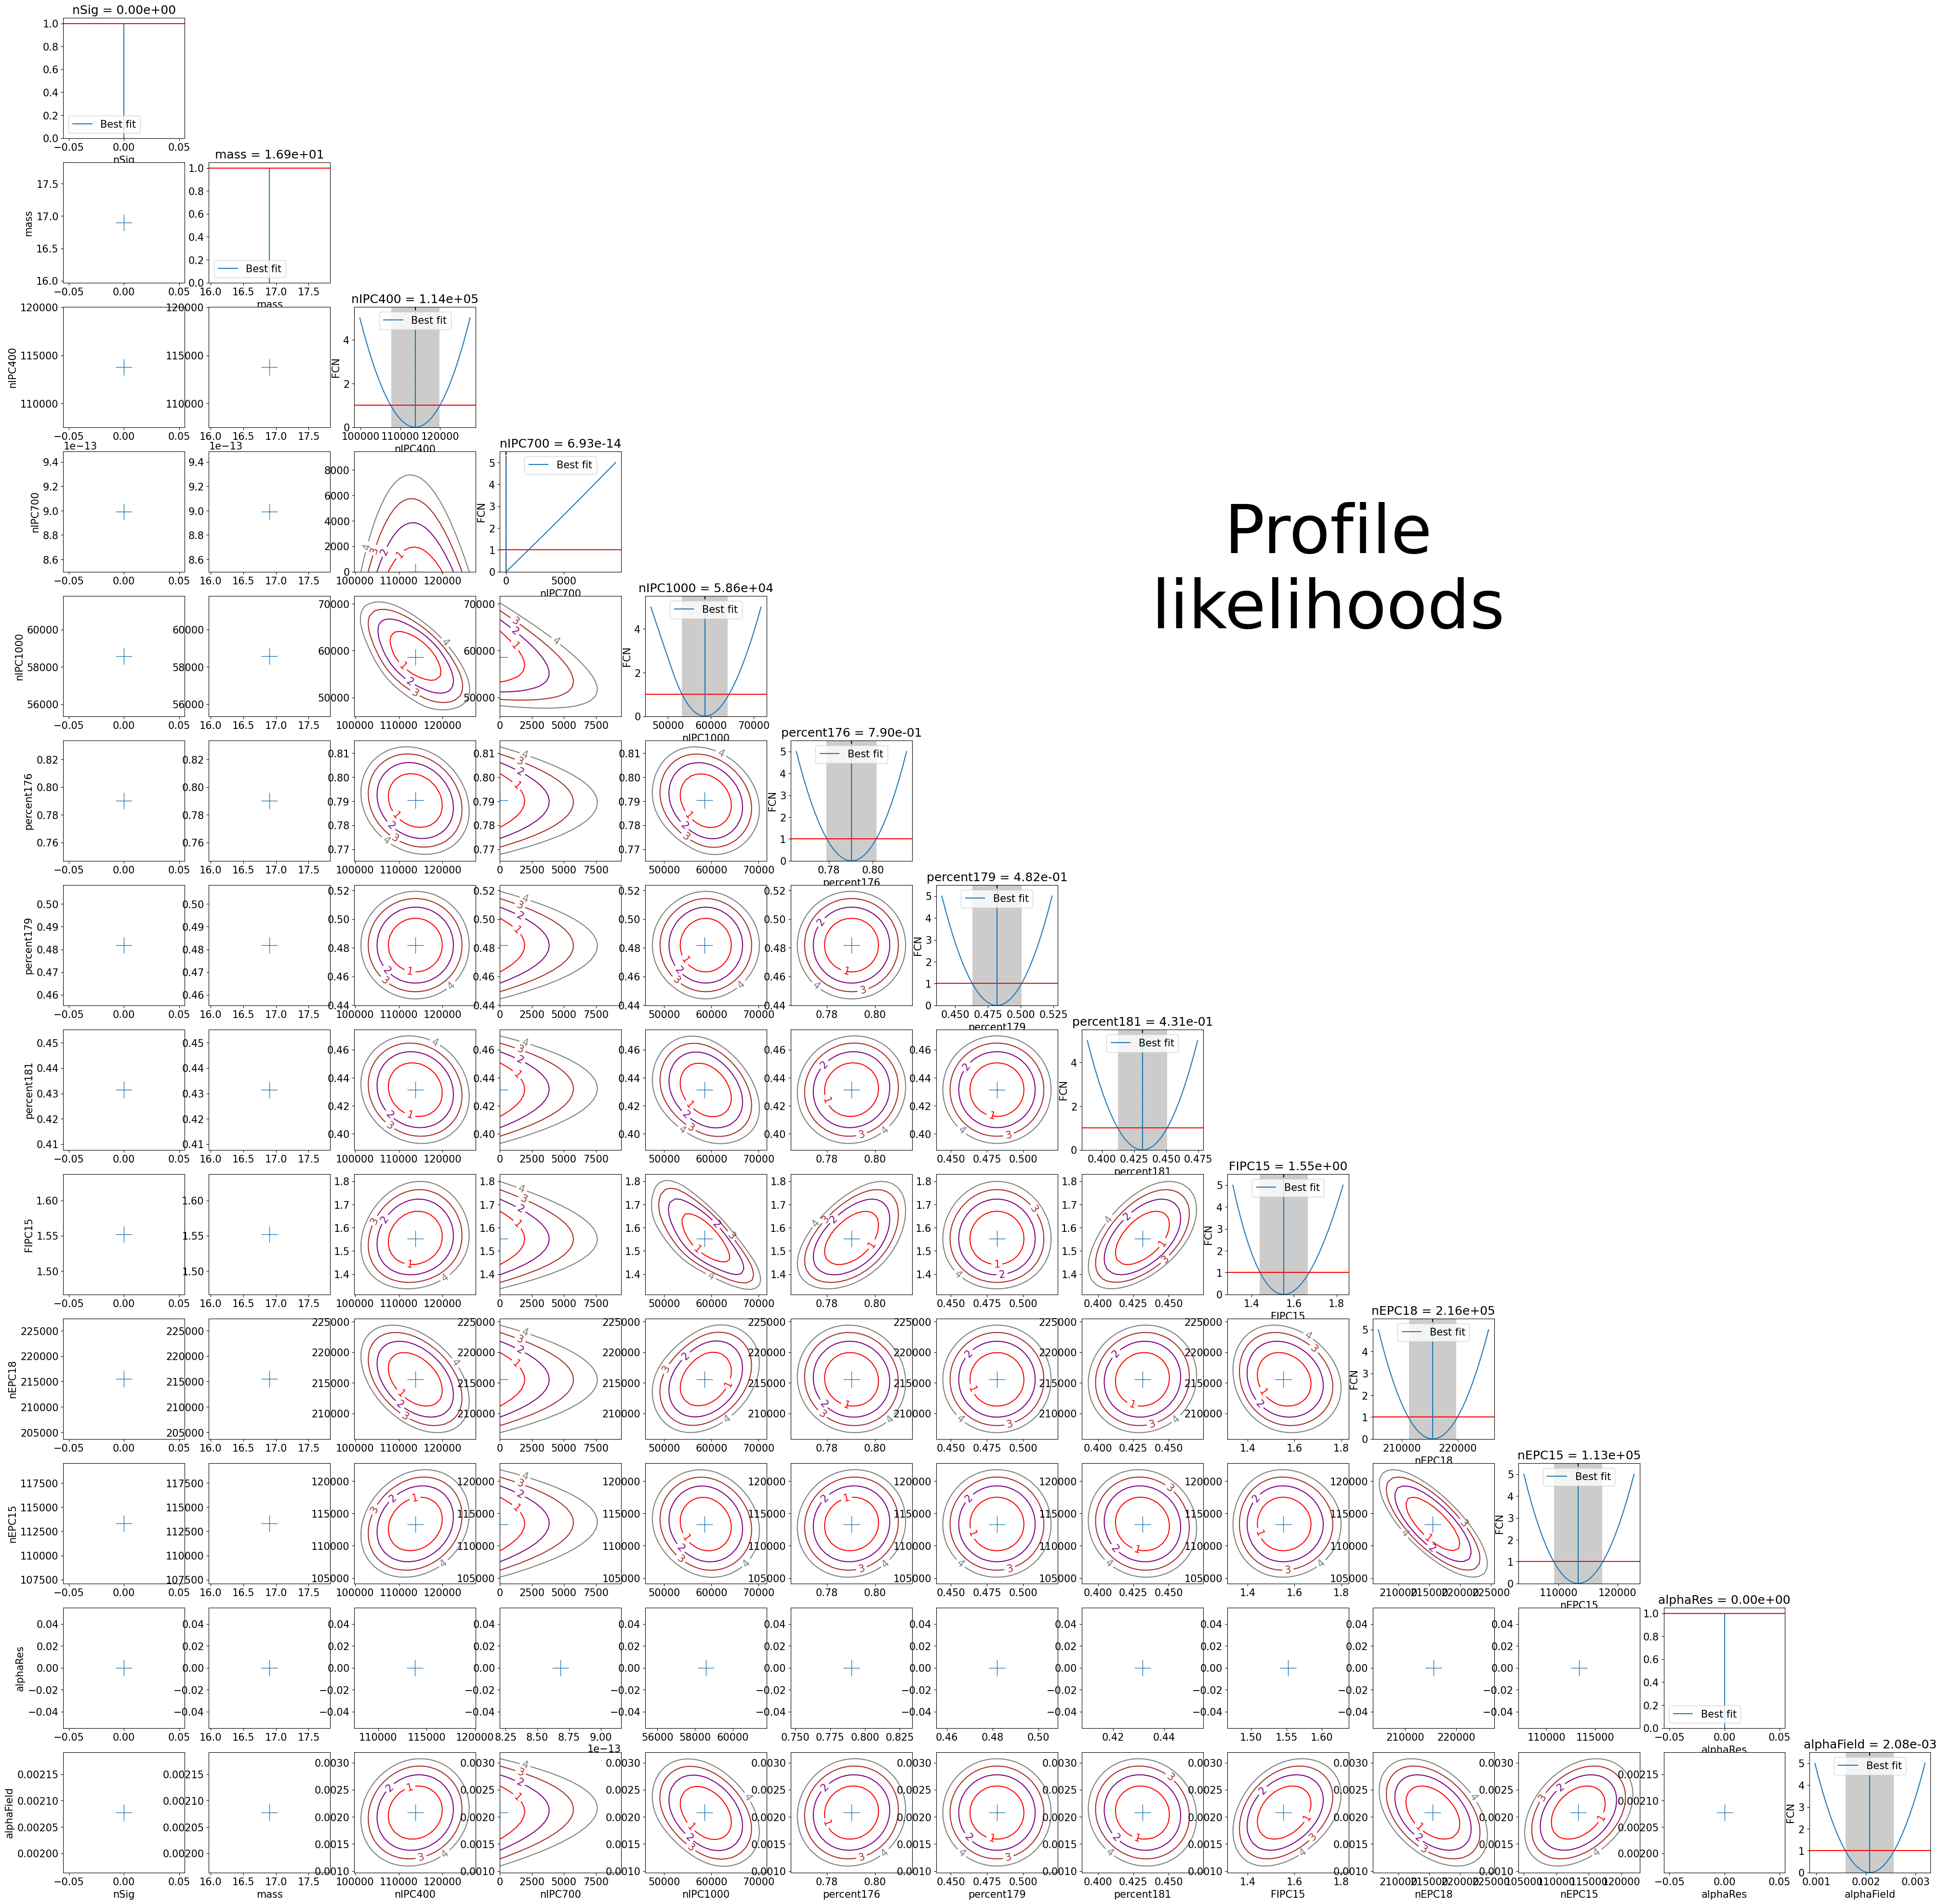

In [132]:
startingPars = np.array([100, 16.9, 4e5, 1e4, 1e4, p176, p179, p181, 1, 1e4, 1e4, 0, 0])
FixedParameters = np.array([False, False, False, False, False, False, False, False, False, False, False, True, False])
logL, betas, MAXLikelihood = bestFit(startingPars, FitToy = False, doNullHypothesis = True, FixedParameters = FixedParameters)

print(logL.fval)
plotComparison(Hists, logL.values, betas, compareWithBetas=False, logL = logL)

if drawMN:
    print(MAXLikelihood)
    drawMNmatrix(logL, np.copy(logL.values), np.copy(logL.errors), steps = 5, MAXLikelihood=MAXLikelihood)
    print(MAXLikelihood)

## Function for the goodness of fit test

Toys are generated to build the Baker-Cousin ratio distribution

In [137]:
PARS = []
Likelihood = []
Accurate = []
Valid = []
totPars = logL.values
BETAS = betas

def GoodnessOfFit(logL, nToys = 100, doNullHypothesis = False, FixedParameters = False, PARS = [], Likelihood = [], Accurate = [], Valid = []):
    startTime = time.time()
    newP176 = logL.values[5]
    newP179 = logL.values[6]
    newP181 = logL.values[7]
    newAlphaField = logL.values[12]
    MAXLikelihood = logL.fval
    
    startToy = len(PARS)
    if startToy > nToys:
        startToy = nToys
    for i in range(startToy, nToys):
        if i % 10 == 0:
            print('Process toy', i, ' - Time:', time.time() - startTime)
        
        np.random.seed(i)
        tpars = np.copy(totPars)
        
        # Sample the nuisances
        if isinstance(FixedParameters, list) or isinstance(FixedParameters, np.ndarray):
            if FixedParameters[5] == False:
                tpars[5] = np.random.normal(newP176, dP176)
                while tpars[5] < 0 or tpars[5] > 1:
                    tpars[5] = np.random.normal(newP176, dP176)
            if FixedParameters[6] == False:
                tpars[6] = np.random.normal(newP179, dP179)
                while tpars[6] < 0 or tpars[6] > 1:
                    tpars[6] = np.random.normal(newP179, dP179)
            if FixedParameters[7] == False:
                tpars[7] = np.random.normal(newP181, dP181)
                while tpars[7] < 0 or tpars[7] > 1:
                    tpars[7] = np.random.normal(newP181, dP181)
            if FixedParameters[12] == False:
                tpars[12] = np.random.normal(newAlphaField, dAlphaField)
                while tpars[12] < alphavalues[1][0] or tpars[12] > alphavalues[1][-1]:
                    tpars[12] = np.random.normal(newAlphaField, dAlphaField)
        elif FixedParameters == False:
            tpars[5] = np.random.normal(newP176, dP176)
            while tpars[5] < 0 or tpars[5] > 1:
                tpars[5] = np.random.normal(newP176, dP176)
            tpars[6] = np.random.normal(newP179, dP179)
            while tpars[6] < 0 or tpars[6] > 1:
                tpars[6] = np.random.normal(newP179, dP179)
            tpars[7] = np.random.normal(newP181, dP181)
            while tpars[7] < 0 or tpars[7] > 1:
                tpars[7] = np.random.normal(newP181, dP181)
            tpars[12] = np.random.normal(newAlphaField, dAlphaField)
            while tpars[12] < alphavalues[1][0] or tpars[12] > alphavalues[1][-1]:
                tpars[12] = np.random.normal(newAlphaField, dAlphaField)
        
        yields = np.concatenate([[tpars[0]], getYields(tpars[2], tpars[3], tpars[4], tpars[5], tpars[6], tpars[7], tpars[8]), [tpars[9], tpars[10]]])
        
        # Sample the toy
        if doNullHypothesis:
            Hists.generateToy(yields[1:], betas = BETAS, fluctuateTemplates = True, morph = tpars[-2:], mass=None)
        else:
            Hists.generateToy(yields, betas = BETAS, fluctuateTemplates = True, morph = tpars[-2:], mass=tpars[1])
        
        # Fit
        logLToy, betasToy, MAXLikelihoodToy = bestFit(tpars, FitToy = True, doNullHypothesis = doNullHypothesis, FixedParameters = FixedParameters)
        
        PARS.append(logLToy.values)
        Likelihood.append(MAXLikelihoodToy)
        Accurate.append(logLToy.accurate)
        Valid.append(logLToy.valid)
    
    PARS = np.array(PARS)
    Likelihood = np.array(Likelihood)
    Accurate = np.array(Accurate)
    Valid = np.array(Valid)
    
    print(logLToy.fval)
    
    plotComparison(Hists, logLToy.values, betasToy, compareWithBetas=True, logL = logLToy, Toy = True)
    plotComparison(Hists, logLToy.values, betasToy, compareWithBetas=False, logL = logLToy, Toy = True)
    
    fig = plt.figure(figsize=(35, 14), dpi=100)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(len(logLToy.parameters)):
        plt.subplot(2, int((len(logLToy.parameters) + 1)*0.5), i+1)
        tpars = np.array([p[i] for p in PARS[Likelihood < 10000]])
        if i < len(logLToy.parameters) - 2:
            plt.hist(tpars/(tpars.mean() + 1*(tpars.mean() ==0)), label= f'Mean: {tpars.mean():.2e}\nStd: {tpars.std():.2e}')
            plt.xlabel(r'$\mathcal{N}_{\mathrm{' + f'{logLToy.parameters[i][1:]}' + r'}}/\mathcal{\hat{N}}_{\mathrm{' + f'{logLToy.parameters[i][1:]}' + r'}}$')
        else:
            plt.hist(tpars, label= f'Mean: {tpars.mean():.2e}\nStd: {tpars.std():.2e}')
            plt.xlabel(logLToy.parameters[i])
        plt.ylabel('Counts')
        plt.legend()
        plt.title(logLToy.parameters[i])

    fig = plt.figure(figsize=(14, 14), dpi=100)
    plt.hist(Likelihood, bins=50, label= 'Number of toys above data likelihood: ' + f'{np.sum(np.array(Likelihood) > MAXLikelihood)/len(Likelihood)*100:.1f}%' + f'\nAverage: {np.mean(Likelihood):.2e}\nStd: {np.std(Likelihood):.2e}')
    plt.vlines(MAXLikelihood, 0, plt.gca().get_ylim()[1], label='Data likelihood', color='k', linestyles='dashed')
    plt.legend()
    plt.xlabel(r'$\log{\mathcal{L}}$')
    return PARS, Likelihood, Accurate, Valid

PARS, Likelihood, Accurate, Valid = GoodnessOfFit(logL, nToys = 100, doNullHypothesis = True, FixedParameters = FixedParameters, PARS = PARS, Likelihood = Likelihood, Accurate = Accurate, Valid = Valid)


Process toy 0  - Time: 5.602836608886719e-05
Process toy 10  - Time: 8.371918201446533


# FC generator

This function takes as an input the value of the best fit, a point in the signal yield vs mass plane, a seed and a number of toys. It writes a file with the seed and the likelihood ratio for each toy and returns the rank of the data in the toys distribution. In the first line of the file there is the data point with its likelihood ratio.

In [ ]:
#def FCgenerator(SignalYield, SignalMass, pars, nToys = 100, betas = 1, nus = 1, fluctuateTemplates = True, FixedParameters = False):
#    # For each toy, sample the not fixed nuisances, sample toys and templates, and compute the log likelihood
    